# Preamble

Analysis of a set of simulation outputs that are the result of a parameter sweep.

## Usage

- Save analysis notebook `lunet_stn-gpe_analysis.ipynb` with cells cleared and hard-coded settings uncommented.


- Edit sweep analysis script `run_notebooks_sweep.py` with correct sweep variable, time interval.


- Run sweep analysis script to execute analysis notebook on all simulation outputs.


- Paste same paths used in script in section 'Load Data'

In [1]:
%matplotlib inline
import os
import cPickle as pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import scipy.stats
from statsmodels.formula.api import ols
import pandas

%load_ext bgcellmodels.extensions.jupyter.skip_cell_extension

## Settings Variables

In [2]:
# SETPARAM: paste output directories below (e.g use ctrl+c in Nautilus file manager)
outputs_clipboard = """
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_19.37.49_job-1293003.sonic-head_syn-V18_f-burst-3.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_19.37.49_job-1293004.sonic-head_syn-V18_f-burst-6.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_19.39.07_job-1293005.sonic-head_syn-V18_f-burst-9.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_19.39.07_job-1293006.sonic-head_syn-V18_f-burst-12.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_19.53.49_job-1293007.sonic-head_syn-V18_f-burst-15.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.03.15_job-1293008.sonic-head_syn-V18_f-burst-18.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.06.30_job-1293009.sonic-head_syn-V18_f-burst-21.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.19.27_job-1293010.sonic-head_syn-V18_f-burst-24.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.23.53_job-1293011.sonic-head_syn-V18_f-burst-27.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.24.09_job-1293012.sonic-head_syn-V18_f-burst-30.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.28.42_job-1293013.sonic-head_syn-V18_f-burst-33.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.35.06_job-1293014.sonic-head_syn-V18_f-burst-36.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.45.15_job-1293015.sonic-head_syn-V18_f-burst-39.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_20.54.28_job-1293016.sonic-head_syn-V18_f-burst-42.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.02.55_job-1293017.sonic-head_syn-V18_f-burst-45.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.10.28_job-1293018.sonic-head_syn-V18_f-burst-48.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.11.02_job-1293019.sonic-head_syn-V18_f-burst-51.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.11.07_job-1293020.sonic-head_syn-V18_f-burst-54.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.19.58_job-1293021.sonic-head_syn-V18_f-burst-57.0-Hz
/home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/LuNetStnGpe_2019.06.10_21.23.25_job-1293022.sonic-head_syn-V18_f-burst-60.0-Hz"""
output_dirs = outputs_clipboard.strip().split()
parent_dir, _ = os.path.split(output_dirs[-1])

In [3]:
# Analysis results for each simulation
analysis_results = {} # dict[sweep_var: float, exported_data: dict]

# SETPARAM: override sweep variable name if desired
sweep_var_name = 'f-burst-ctx'
# SETPARAM: description of sweep variable for figure legends
sweep_var_legend = "$f_{burst,CTX}$ (Hz)" # LaTeX expressions allowed, double backslashes (\ -> \\)

# SETPARAM: filename of pickle files to load
pickle_filename = 'analysis_results_3.0s-7.0s_phase-from-ctx' # 'analysis_results_6.0s-10.0s_DRIVEN.pkl'

# SETPARAM: suffix for all exported files
export_suffix = 'sweep-f-burst-ctx'
report_filename = 'meta-report_{}.html'.format(export_suffix)
meta_sweep_dir = os.path.join(parent_dir, 'sweep-meta_analysis')
meta_sweep_fname = 'meta-metrics_{}.pkl'.format(export_suffix)

# SETPARAM: save figures
export_figs = True
export_figs_dir = os.path.join(meta_sweep_dir, 'figs_' + report_filename[:-5])

# SETPARAM: whether cortical bursting input is given
without_ctx_bursting = False

# SETPARAM: Entries in output_dirs with incorrect sweep variable
custom_outputs = { 
#     len(output_dirs)-1 : 1.0,
}
override_sweep_vals = None # np.round(np.arange(1./3, 3+1./3, 1./3), 2)

## Load Data

In [4]:
# Gather simulation results in dictionary
for i, odir in enumerate(output_dirs):
    export_file = os.path.join(odir, pickle_filename)
    with open(export_file, 'rb') as f:
        results_dict = pickle.load(f)
        
        if sweep_var_name is None and i == 0:
            sweep_var_name = results_dict['sweep_settings']['var_name']
        
        if i in custom_outputs.keys():
            sweep_value = custom_outputs[i]
        elif override_sweep_vals is not None:
            sweep_value = override_sweep_vals[i]
        else:
            sweep_value = float(results_dict['sweep_settings']['var_value'])
            
#         elif sweep_var_name == results_dict['sweep_var_name']:
#             sweep_value = results_dict['sweep_var_value']
#         else:
#             raise ValueError(
#                 "Simulation results in {} do not have the intended sweep variable!"
#                 "\nMaybe one of the output directories you copied does not match the series.".format(odir))
        
        # Extract sweep value from filename
        # import re
        # match = re.search(r'[0-9]+$', odir)
        # sweep_value = float(match.group(0))
        
        # Use saved sweep value
        analysis_results[sweep_value] = results_dict

In [5]:
sweep_vals = np.array(sorted(analysis_results.keys()))
print(sweep_vals)
print(analysis_results.values()[0].keys())

[ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45. 48. 51. 54.
 57. 60.]
['coherence_vmean', 'I_exc_inh_ratio', 'Morgera_index', 'sweep_settings', 'I_afferents', 'burst_metrics', 'populations', 'cell_phase_vecs', 'coherence_composite', 'spectrogram', 'analyzed_interval', 'phaselock_ranking_source_ids', 'PSD', 'mean_rate', 'sim_config', 'phaselock_ranking_source_indices', 'pop_phase_vecs']


## Saved Data

In [6]:
# root dict for pickling
sweep_meta_results = {
    'sweep_var_name': sweep_var_name,
    'sweep_var_legend': sweep_var_legend,
    'sweep_values' : sweep_vals,
    'netsim_analysis_pickle_filename': pickle_filename,
}

## Plotting Options

In [7]:
# figures output dir
if export_figs and not os.path.exists(export_figs_dir):
    os.makedirs(export_figs_dir)

# Figure dimensions
fig_aspect_ratio = 2.2 # 8.0 / 3.0
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception() # fix bug for notebook backend where figures not shown
    page_width = 10
else:
    page_width = 10

fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio
ax_width = 0.6 * page_width
ax_height = ax_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

## Support Functions

In [8]:
def save_figure(fname, fig=None, **kwargs):
    """
    Save given or current figure.
    For LaTeX embedding, use extension pdf/pgf/eps in the figure name.
    
    kwargs: see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html
    """
    kwargs.setdefault('bbox_inches', 'tight') # prevents cropping
    kwargs.setdefault('transparent', True) # transparent background, see also 'frameon'
    fname += '.' + kwargs.setdefault('format', 'pdf')
    fig_filepath = os.path.join(export_figs_dir, fname)
    if fig is None:
        plt.savefig(fig_filepath, **kwargs) # save current figure
    else:
        fig.savefig(fig_filepath, **kwargs) # save specific figure
    print("Figure saved to file {}".format(fig_filepath))
    return fig_filepath

def offset_show_twin_yax(ax, offset=1.2):
    """
    Having been created by twinx, ax has its frame off, so the line of its
    detached spine is invisible.  First, activate the frame but make the patch
    and spines invisible. Then make the detached spine visible.
    """
    ax.spines["right"].set_position(("axes", offset))
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines["right"].set_visible(True)

def set_axes_size(w, h, ax=None):
    """
    Set the size of the axes (plotting area) instead of the whole figure
    which is the default.
    
    w, h: width, height in inches
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [9]:
# Get stylesheet colors, depends on stylesheet specified using plt.style.use('palette')
style_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Define color for each population
line_colors = 'crkgbm'
populations = 'CTX', 'STN', 'STN.surrogate', 'GPE.proto', 'GPE.surrogate', 'STR.MSN' # TODO: load from exported vars
pop_color_map = {k: line_colors[i % len(line_colors)] for i,k in enumerate(sorted(populations))}
pop_color_map['GPE'] = pop_color_map['GPE.proto']
pop_color_map['GPE.all'] = pop_color_map['GPE.proto']

def get_pop_color(pop_label):
    return pop_color_map[pop_label]

pop_descriptions = {'STN': 'STN', 'GPE.proto': 'GPe', 'CTX': 'CTX'}
def get_pop_legend(pop_label):
    """ Population description for figure legends. """
    return pop_descriptions[pop_label]

In [34]:
def integrate_subband(freqs, vals, fband, normalize=True):
    mask1 = (freqs >= fband[0]) & (freqs <= fband[1])
    mask2 = np.isclose(freqs, fband[0], atol=0.1) | np.isclose(freqs, fband[1], atol=0.1)
    fband_idx, = np.where(mask1 | mask2)
    return np.sum(vals[fband_idx]) / len(fband_idx)

# Sec 1 - Balance EXC/INH

## Rates + _invivo_ bounds

It is useful to plot firing rates to spot differences between the simulations that may underlie certain results.

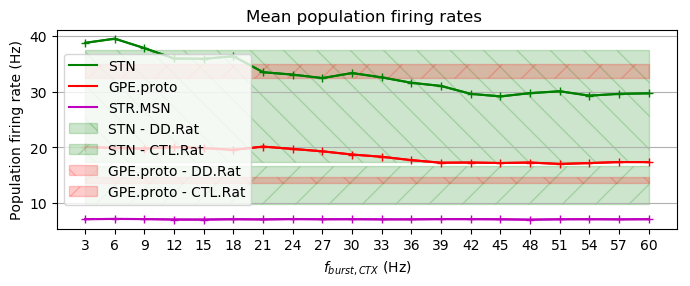

In [11]:
# Plot mean firing rates
sweep_vals = np.array(sorted(analysis_results.keys()))

fig, ax = plt.subplots(figsize=(0.8*page_width, ax_height))
ax.set_title('Mean population firing rates ')
plotted = []

for pop in 'STN', 'GPE.proto', 'STR.MSN':
    rates = [analysis_results[val]['mean_rate'][pop] for val in sweep_vals]
    color = get_pop_color(pop)
    plotted.extend(ax.plot(sweep_vals, rates, color=color, label=pop))
    plotted.extend(ax.plot(sweep_vals, rates, color=color, marker='+'))

# Plot experimental rates
invivo_rates = {
    'GPE.proto': {
        'CTL.Rat': [32.4, 35.0], # Sleep-Act.Mallet2008
        'DD.Rat': [13.6, 14.6], # Sleep-Act.Mallet2008
    },
    'STN': {
        'CTL.Rat': [9.8, 16.6], # Sleep-Act.Mallet2008-Kita2011
        'DD.Rat': [17.3, 37.4], # Sleep-Act.Mallet2008-Kita2011
    }
}
for i, pop_label in enumerate(('STN', 'GPE.proto')):
    for j, src_rates in enumerate(invivo_rates.get(pop_label, {}).items()):
        label, bounds = src_rates
        color = get_pop_color(pop_label)
        line_kwargs = {'color': color, 'alpha': 0.2, 'linewidth': 1.0, 
                       'hatch': '\\' if label.startswith('DD') else '/',
                       'label': '{} - {}'.format(pop_label, label)}
        plotted.append(ax.fill_between(sweep_vals, bounds[0], bounds[1], **line_kwargs))
        # ax.hlines(bounds, x0, x1, **line_kwargs)
    
# Axes & Legend
ax.set_xlabel(sweep_var_legend)
ax.set_ylabel('Population firing rate (Hz)')
fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
ax.set_xticks(sweep_vals)
# # ax.set_xticklabels(sweep_vals)
# # ax.set_yticks(np.arange(0, int(max(rates)+2), 5), minor=False)
# # ax.set_yticks(np.arange(0, int(max(rates)+2), 1.0), minor=True)
ax.grid(True, axis='y')
ax.legend()

# Plot legend in separate figure
# fig, ax = plt.subplots()
# fig.legend(plotted, [p.get_label() for p in plotted], loc='upper center', frameon=False)
# ax.axis('off')

## Rates + EXC / INH ratio

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/pop_rates_EI-ratios.pdf


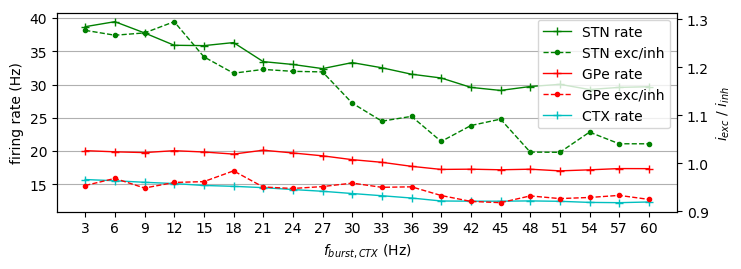

In [12]:
fig, ax1 = plt.subplots(figsize=(0.8*page_width, ax_height))
ax2 = ax1.twinx()
actors = []

sweep_vals = np.array(sorted(analysis_results.keys()))

for pop in 'STN', 'GPE.proto', 'CTX':
    color = get_pop_color(pop)
    
    # Plot rates on left axis
    rates = [analysis_results[val]['mean_rate'][pop] for val in sweep_vals]
    actors.extend(
        ax1.plot(sweep_vals, rates, '-', marker='+', linewidth=1,
                 color=color, label='{} rate'.format(get_pop_legend(pop))))

    # Plot EXC/INH ratio on right axis
    if pop in analysis_results[val]['I_exc_inh_ratio']:
        ratios = [analysis_results[val]['I_exc_inh_ratio'][pop] for val in sweep_vals]
        actors.extend(
            ax2.plot(sweep_vals, ratios, '--', marker='.', linewidth=1, color=color,
                     label='{} exc/inh'.format(get_pop_legend(pop))))


# Axes ticks
ax = ax1
ax.set_xlabel(sweep_var_legend)
ax.set_xticks(sweep_vals)
ax.grid(True, axis='y')
fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

# Axes labels
ax1.set_ylabel('firing rate (Hz)')
ax2.set_ylabel('$i_{exc}$ / $i_{inh}$')
# ax2.set_ylim((0, 2))

# Legend
legend_color_only = False
if legend_color_only:
    # draw custom legend with only line color
    pops = 'STN', 'GPE.proto'
    legend_symbols = [Line2D([0], [0], color=get_pop_color(pop)) for pop in pops]
    legend_labels = [get_pop_legend(pop) for pop in pops]
    ax.legend(legend_symbols, legend_labels, loc='best')
else:
    # all lines from ax1 and ax2 in legend
    ax.legend(actors, [a.get_label() for a in actors], loc='best')

if export_figs:
    save_figure('pop_rates_EI-ratios')

## Currents + E/I + rate

Ratio of afferent currents for each population

In [13]:
def plot_afferent_currents(pop_label, export=False, legend_loc='best',
                           fmax=None, fmin=None, EImin=None, EImax=None):
    """
    Plot ratio of afferent currents as filled region under graph.
    """
    global sweep_meta_results
    if 'I_afferents' not in analysis_results.values()[0]:
        print("Detailed afferent currents info not saved. Skipping plot.")
        return
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title('{} total afferent currents'.format(pop_label))
    leg_actors = [] # actors in figure that will get legend
    
    # Total current for each afferent as array for each sweep value
    # NOTE: total only over sampled cells, not entire population
    sweep_vals = np.array(sorted(analysis_results.keys()))
    sweep_itot_data = [analysis_results[val]['I_afferents'][pop_label] for val in sweep_vals]
    pops_sweep_itot = {aff: [] for aff in sweep_itot_data[0][0].keys() if aff not in ('EXC', 'INH')}
    
    itot_neg_cumul = np.zeros_like(sweep_vals)
    itot_pos_cumul = np.zeros_like(sweep_vals)
    itot_neg_lines = [itot_neg_cumul]
    itot_pos_lines = [itot_pos_cumul]
    itot_neg_vals = []
    itot_pos_vals = []
    
    for i, pop in enumerate(pops_sweep_itot.keys()):
        sweep_itot = np.array([sum((sum(cell_iaff[pop].values()) for cell_iaff in itot_data)) 
                                 for itot_data in sweep_itot_data])
        pl = pop.split('.')[0]
        fill_color = style_color_cycle[i] # get_pop_color(pop)
    
        if sweep_itot.mean() > 0: # inhibitory current -> make negative
            itot_neg_vals.append(sweep_itot)
            itot_neg_lines.append(itot_neg_lines[-1] - sweep_itot)
            ax.plot(sweep_vals, itot_neg_lines[-1], color='blue', alpha=0.7)
            actors = ax.fill_between(sweep_vals, itot_neg_lines[-2], itot_neg_lines[-1],
                                     color=fill_color, alpha=0.5,
                                     label='$i_{{{0}}}$'.format(pl))
        else:                    # excitatory current -> make positive
            itot_pos_vals.append(sweep_itot)
            itot_pos_lines.append(itot_pos_lines[-1] - sweep_itot)
            ax.plot(sweep_vals, itot_pos_lines[-1], color='blue', alpha=0.7)
            actors = ax.fill_between(sweep_vals, itot_pos_lines[-2], itot_pos_lines[-1],
                                     color=fill_color, alpha=0.5,
                                     label='$i_{{{0}}}$'.format(pl))
        leg_actors.append(actors)
    
    # Center axes on zero
    i_lim = max(np.abs(itot_neg_lines[-1]).max(), np.abs(itot_pos_lines[-1]).max())
    ax.set_ylim((-1.1*i_lim, 1.1*i_lim))
    
    # Draw zero level
    ax.plot(sweep_vals, itot_pos_lines[0], color='grey', alpha=0.7)
    
    # Plot sum of all currents
    itot_all_cumul = -np.sum(itot_pos_vals, axis=0) - np.sum(itot_neg_vals, axis=0)
    act1, = ax.plot(sweep_vals, itot_all_cumul, '--', color='blue', linewidth=1, 
                    marker='x', markersize=6, label='i (tot)')
    leg_actors.append(act1)
    
    # Plot ratio EXC/INH
    itot_all_ratio = -np.sum(itot_pos_vals, axis=0) / np.sum(itot_neg_vals, axis=0)
    sweep_meta_results.setdefault('EI_ratio', {})[pop_label] = itot_all_ratio
    
    ax2 = ax.twinx()
    act2, = ax2.plot(sweep_vals, itot_all_ratio, 'r--', linewidth=1, 
                     marker='x', markersize=6, label='ratio')
    ax2.set_ylabel('ratio $i_{EXC}$ / $i_{INH}$', color=act2.get_color())
    ax2.tick_params(axis='y', colors=act2.get_color(), size=4, width=1.5)
    ratio_lim = np.abs(itot_all_ratio).max()
    if EImax is None:
        EImax = 1.1*ratio_lim
    if EImin is None:
        EImin = -EImax
    ax2.set_ylim((EImin, EImax))
    
    # Plot firing rate
    rates = [analysis_results[val]['mean_rate'][pop_label] for val in sweep_vals]
    ax3 = ax.twinx()
    offset_show_twin_yax(ax3, offset=1.12)
    act3, = ax3.plot(sweep_vals, rates, 'g--', marker='x', linewidth=1,
                     markersize=6, label='rate')
    ax3.set_ylabel('population firing rate (Hz)', color=act3.get_color()) # ax3.yaxis.label.set_color(act3.get_color())
    ax3.tick_params(axis='y', colors=act3.get_color(), size=4, width=1.5)
    if fmax is None:
        fmax = 1.1 * max(rates)
    if fmin is None:
        fmin = -fmax
    ax3.set_ylim((fmin, fmax))
    
    # Axes & labels
    ax.set_xticks(sweep_vals)
    # ax.set_xlim((min(sweep_vals), max(sweep_vals)))
    ax.set_ylabel('current (nA)', color='blue')
    ax.tick_params(axis='y', colors=act1.get_color(), size=4, width=1.5)
    ax.set_xlabel(sweep_var_legend)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # scientific notation without exponent
    # ax.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False) # with exponent
    ax.grid(True)
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    # Draw legend
    ax.legend(leg_actors, [a.get_label() for a in leg_actors], loc=legend_loc)
    
    set_axes_size(ax_width, ax_height, ax)
    if export_figs:
        fname = 'afferent-currents_{}'.format(pop_label)
        save_figure(fname, fig=fig, bbox_inches='tight') # bbox_extra_artists=[ax3.yaxis.label]

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/afferent-currents_STN.pdf
Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/afferent-currents_GPE.proto.pdf


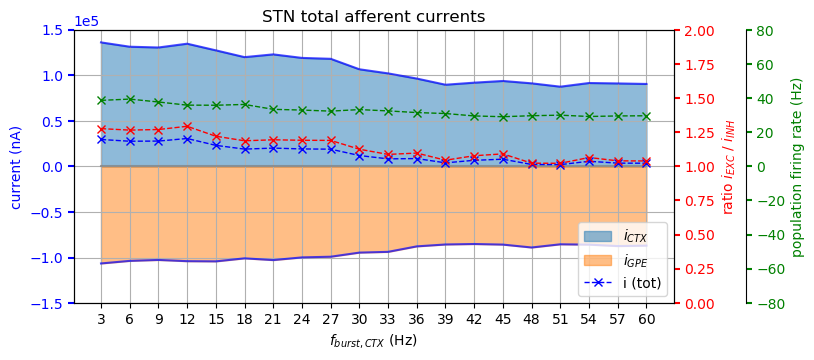

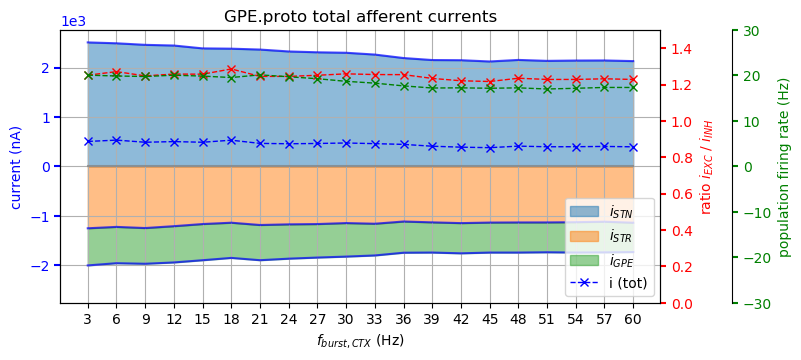

In [14]:
plot_afferent_currents('STN', fmin=-80, fmax=80, EImin=0.0, EImax=2.0, legend_loc='lower right')
plot_afferent_currents('GPE.proto', fmin=-30, fmax=30, EImin=0.0, EImax=1.5, legend_loc='lower right')

## 1A : PSD vs EXC/INH ratio

### PSD 'sweep-gram'

In [53]:
def compare_psd_heatmap(sig_label, x_axis_equidistant=True, Plim=None, f_max=50.0,
                        figsize=(fig_width, fig_height), cmap='viridis', export=False,
                        dy_minor=5.0, dy_major=20.0, log_psd=False, sweep_val_format='{:.2f}'):
    """
    Compare PSD across parameter sweep using heatmap visualization.
    
    @param  x_axis_equidistant : bool
            If true, x axis will be spaces equidistanctly, and missing values
            will be filled by black bands.
    """
    
    # Concatenate PSDs of different sweep values into matrix
    test_freqs, test_psd = analysis_results.values()[0]['PSD'][sig_label]
    freq_res = test_freqs[1] - test_freqs[0]
    fmax = 100.0
    nfreq = int(fmax/freq_res) + 1

    # Sweep values may not be equidistantly spaced
    sweep_vals = np.array(sorted(analysis_results.keys()))
    d_sweep = min(np.diff(sweep_vals)) # resolution of sweep variable
    sweep_axis_spaced = np.arange(sweep_vals.min(), sweep_vals.max()+d_sweep, d_sweep)
    sweep_axis_full = list(sweep_axis_spaced)
    for v in sweep_vals: # steps may miss actual values
        if not np.any(np.isclose(v, sweep_axis_full)):
            sweep_axis_full.append(v)
    if x_axis_equidistant:
        sweep_axis = np.array(sorted(sweep_axis_full))
    else:
        sweep_axis = sweep_vals

    # Cronstruct image (heatmap) matrix
    freq_axis = test_freqs[:nfreq]
    sweep_psds = np.empty((nfreq, sweep_axis.size), dtype=float)
    valid_columns = []
    for sweep_value, results in analysis_results.iteritems():
        # col_id = int((sweep_value - sweep_axis.min())/d_sweep)
        col_id = np.where(np.isclose(sweep_value, sweep_axis))[0][0]
        valid_columns.append(col_id)
        freqs, psd = results['PSD'][sig_label]
        sweep_psds[:, col_id] = psd.magnitude[:nfreq]

    # Fill columns for missing sweep values with NaN
    invalid_columns = [i for i in range(sweep_axis.size) if i not in valid_columns]
    sweep_psds[:, invalid_columns] = np.nan
    psd_vals = np.ma.masked_array(sweep_psds, np.isnan(sweep_psds)) # mark invalid/missing data
    if log_psd:
        psd_vals = np.log10(psd_vals)

    # Draw heat map
    cmap = plt.get_cmap(cmap) # e.g. jet, plasma: https://matplotlib.org/examples/color/colormaps_reference.html
    cmap.set_bad(color='k') # color for masked values

    fig, ax = plt.subplots(figsize=figsize)
    sweep_plotaxis = np.concatenate((sweep_axis, [sweep_axis.max()+d_sweep])) # fix bug/feature in pcolormesh
    pcol = plt.pcolormesh(sweep_plotaxis, freq_axis, psd_vals, cmap=cmap, linewidth=0, rasterized=True)
    # pcol.set_edgecolor('face') # get rid of edge rendering in pdf output
    if Plim is not None:
        plt.clim(*Plim)

    # f_max = 50
    # plt.ylim((0, f_max))
    plt.colorbar()
    
    # cmap.set_bad('grey')
    ax.set_xticks(sweep_axis + d_sweep/2.0) # otherwise they appear left of column
    ax.set_xticklabels([sweep_val_format.format(v) for v in sweep_axis])
    ax.set_xlim((sweep_axis.min(), sweep_plotaxis.max()))
    ax.set_yticks(np.arange(0,f_max+dy_minor, dy_minor), minor=True)
    ax.set_yticks(np.arange(0,f_max+dy_major, dy_major), minor=False)
    ax.set_ylim((0, f_max))
    # TODO: find out why one column doesn't show

    plt.ylabel('frequency (Hz)')
    plt.xlabel(sweep_var_legend)
    plt.suptitle('Evolution of PSD ({})'.format(sig_label))
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    # set_axes_size(ax_width, ax_height, ax)
    if export_figs and export:
        fname = 'PSDs-heatmap_{}'.format(sig_label)
        save_figure(fname, fig=fig)

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/PSDs-heatmap_STN_Vm.pdf
Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/PSDs-heatmap_GPE.proto_Vm.pdf


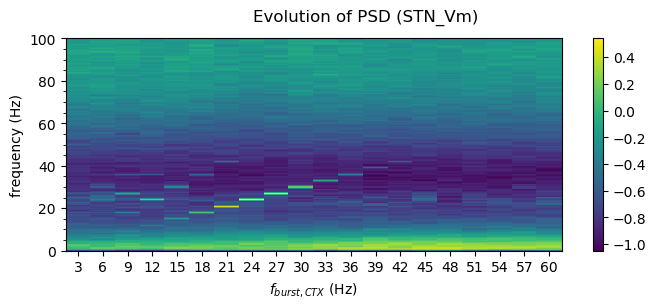

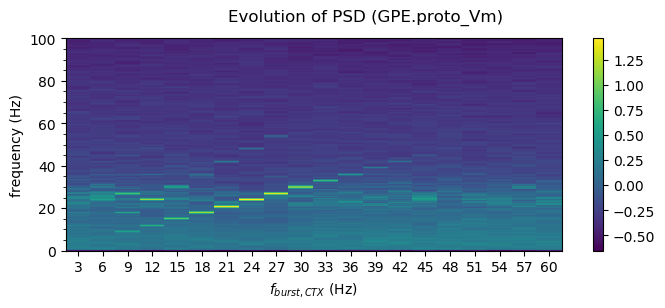

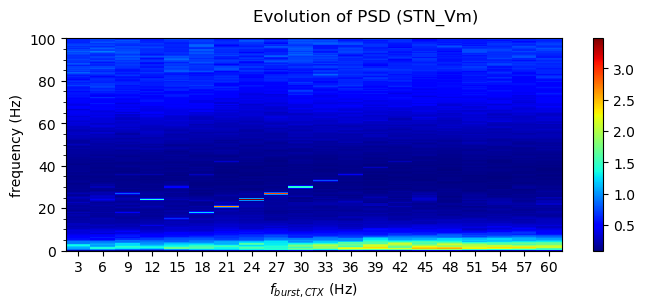

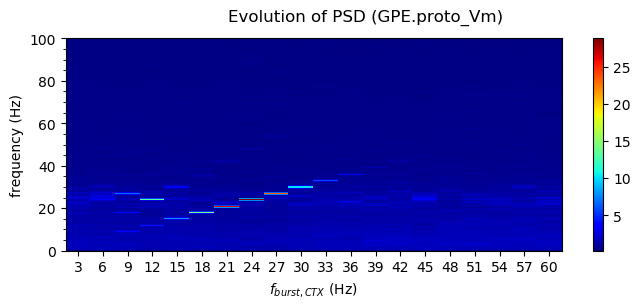

In [57]:
figsize = (fig_width, fig_width/2.75)

compare_psd_heatmap('STN_Vm', False, f_max=100.0, log_psd=True, # Plim=(-.5, 1.4),
                    figsize=figsize, sweep_val_format='{:.0f}')
compare_psd_heatmap('GPE.proto_Vm', False, f_max=100.0, log_psd=True, # Plim=(-.5, 1.4),
                    figsize=figsize, sweep_val_format='{:.0f}')

compare_psd_heatmap('STN_Vm', False, log_psd=False, f_max=100.0, # Pmax=0.5, 
                    cmap='jet', export=True, figsize=figsize, sweep_val_format='{:.0f}')

compare_psd_heatmap('GPE.proto_Vm', False, log_psd=False, f_max=100.0, # Pmax=0.5
                    cmap='jet', export=True, figsize=figsize, sweep_val_format='{:.0f}')

### PSDs superimposed

In [17]:
# Plot the PSD
sig_label = 'STN_Vm'
sweep_vals = np.array(sorted(analysis_results.keys()))

# Sampling colors from linear scale:
# https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
cmap = plt.get_cmap('cool')

# Line colors equidistantly on color scale, independent of sweep values
line_colors = [cmap(x) for x in np.linspace(0, 1, len(analysis_results))]
def get_line_color(sweep_val):
    return cmap(float(sweep_val) / sweep_vals.max)

# Linear map of sweep values to color scale
cNorm  = matplotlib.colors.Normalize(vmin=sweep_vals[0], vmax=sweep_vals[-1])
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
def get_line_color(sweep_val):
    return scalarMap.to_rgba(sweep_val)

def compare_psd(sig_label, legend=False, colorbar=True, width=fig_width, height=fig_height):
    """ Plot PSD for given signal for each simulation / sweep variable. """
    if colorbar:
        ncols = 2
        # axes for colorbar must be smaller
        subplot_kwargs = {'gridspec_kw': {'width_ratios':[20, 1]}}
    else:
        ncols = 1
        subplot_kwargs = {}
    
    fig, axes = plt.subplots(1, ncols, figsize=(width, height), **subplot_kwargs)
    if colorbar:
        ax = axes[0]
    else:
        ax = axes
    
    # Plot PSD as line for  each sweep value
    sweep_vals = np.array(sorted(analysis_results.keys()))
    lines = []
    for i, sweep_value in enumerate(sweep_vals):
        results = analysis_results[sweep_value]
        freqs, psd = results['PSD'][sig_label]
        plotted = ax.plot(freqs, psd,
                          color=get_line_color(sweep_value), 
                          label='{} = {}'.format(sweep_var_legend, sweep_value))
        lines.extend(plotted)
    
    ax.set_ylabel('Power ({})'.format(psd.units))
    ax.set_xlabel('frequency ({})'.format(freqs.units))
    ax.set_xticks(np.arange(0,55,5), minor=False)
    ax.set_xticks(np.arange(0,51,1), minor=True)
    ax.grid(True)
    ax.set_xlim((0, 35))
    # ax.set_yscale('log')
    ax.set_title('Welch PSD for {}'.format(sig_label))
    if legend:
        if len(sweep_vals) < 7:
            ax.legend(loc='upper right', bbox_to_anchor=(1,1))
        else:
            lower = slice(7)
            upper = slice(7, len(sweep_vals))
            labels = ['{} = {}'.format(sweep_var_legend, v) for v in sweep_vals]
            # 'loc' is corner of legend anchored to anchorpoint
            # 'bbox_to_anchor' is location of anchorpoint on axis bounding box
            leg1 = ax.legend(lines[lower], labels[lower], loc=1, bbox_to_anchor=(.82,1))
            leg2 = ax.legend(lines[upper], labels[upper], loc=2, bbox_to_anchor=(.82,1))
            ax.add_artist(leg1) # otherwise last legend is used
    if colorbar:
        ax = axes[1]
        # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.colorbar.html
        cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=cNorm, ticks=sweep_vals,
                                              orientation='vertical')
        cb.set_label(sweep_var_legend)
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

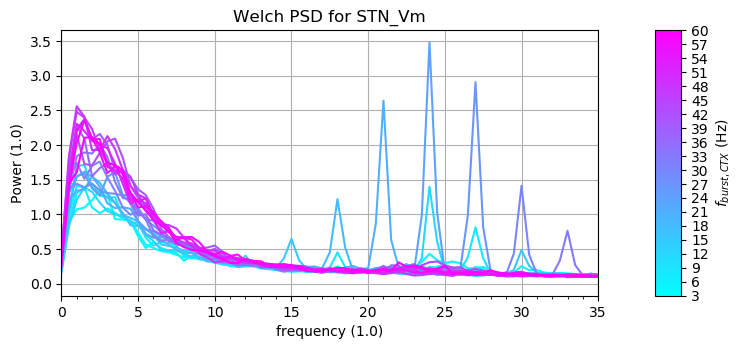

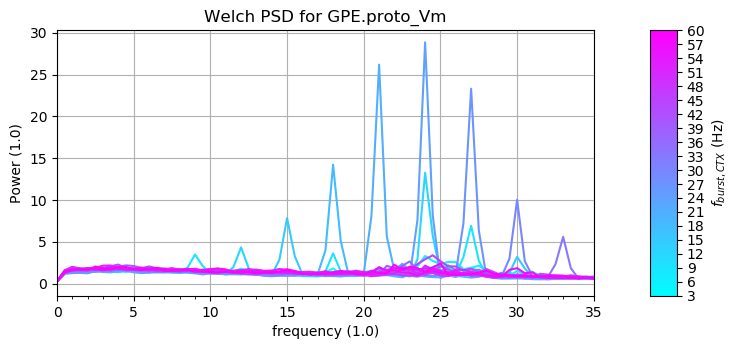

In [18]:
compare_psd('STN_Vm')
compare_psd('GPE.proto_Vm')

### PSD integrated

Summed PSD power in different frequency bands.

In [19]:
def psd_power_integrated(pop_labels, f_band, detailed=True, independent='sweep', **kwargs):
    """
    Linear regression of integrated composite coherence.
    
    @param    independent : str
              Independent variable for plot x-axis and linear regression
    
    @param    x_label : str
              label for independent variable
    
    @param    x_ticks : list(float)
              Axes ticks for x-axis
    """
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title('mean(PSD) between {} - {} Hz'.format(f_band[0], f_band[1]))
    
    # Set independent variable for regression
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if independent == 'sweep':
        x = sweep_vals
        x_label = sweep_var_legend
        x_ticks = sweep_vals
    elif independent == 'custom':
        x = kwargs['x']
        x_label = kwargs['x_label']
        x_ticks = kwargs.get('x_ticks', None)
    else:
        raise ValueError("Argument <independent> must be either 'sweep', 'exc_inh_ratio', or 'custom'.")
    
    if isinstance(pop_labels, str):
        pop_labels = [pop_labels]
        
    for i_pop, pop_label in enumerate(pop_labels):
        sig_label = pop_label + '_Vm'

        all_Psum = []
        for i, sweep_value in enumerate(sweep_vals):
            f, Pxx = analysis_results[sweep_value]['PSD'][sig_label]
            all_Psum.append(integrate_subband(f.magnitude, Pxx.magnitude, f_band))

        # Linear regression
        metric_name = 'Pxx'
        y = np.array(all_Psum)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

        # Detailed linear regression
        if detailed:
            data = pandas.DataFrame({'x': x, metric_name: y})
            model = ols("{} ~ {}".format(metric_name, 'x'), data).fit()
            print(model.summary()) # summary2()
        
        # Save results
        sweep_meta_results.setdefault('PSD_integrated', {})\
                          .setdefault(pop_label, {})[tuple(f_band)] = y
        
        # Scatter plot + linear fit
        color = get_pop_color(pop_label)
        ax.plot(x, y, 'o', color=color, label=pop_label)
        ax.plot(x, intercept + slope*x, '-', color=color, lw=1, label='linear fit')
        
        # Print regression statistics
        ax.text(.98, .05 + i_pop * .20, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
                color=color, transform=ax.transAxes, ha='right')
    
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    ax.set_ylabel('Power ($mV^2/Hz$)')
    ax.set_xlabel(x_label)
    ax.grid(True)
    ax.legend()
    
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    

In [38]:
def psd_integrated_summary(pops, f_band, Pmax=None, cmap='Set2', export=False, title=None):
    """
    Composite spiketrain coherence integrated in different frequency bands.
    
    @param    f_band : tuple[float, float]
              Frequency band as tuple or list of tuples in case a different frequency band
              is desired for each simulation result.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if len(pops) > 1:
        pop_a, pop_b = pops
        key = '{}-{}'.format(pop_a, pop_b)
    else:
        key = pops[0]
    
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    if len(f_band) == 2:
        ax.set_title('{} PSD integrated in [{}, {}] Hz'.format(key, *f_band))
    elif title:
        ax.set_title(title)
    cmap = plt.get_cmap(cmap)
    
    # Set independent variable
    sweep_vals = np.array(sorted(analysis_results.keys()))
    x = sweep_vals
    x_label = sweep_var_legend
    x_ticks = sweep_vals
    
    # Integrated PSD power in all bands
    for i_pop, pop_label in enumerate(pops):
        sig_label = pop_label + '_Vm'
        
        # Calculate integrated power
        all_Psum = []
        for i, sweep_value in enumerate(sweep_vals):
            f, Pxx = analysis_results[sweep_value]['PSD'][sig_label]
            if len(f_band) > 2:
                f_limits = f_band[i]
            else:
                f_limits = f_band
            all_Psum.append(integrate_subband(f.magnitude, Pxx.magnitude, f_limits))
        y = np.array(all_Psum)

        # Plot power for sweep
        color = get_pop_color(pop_label)
        line_label = pop_label.split('.')[0]
        ax.plot(x, y, '--', marker='.', color=color,
                linewidth=1, markersize=6, label=line_label)
        
    # Axes and legend
    if Pmax is None:
        ax.set_ylim((0, ax.get_ylim()[1]))
    else:
        ax.set_ylim((0, Pmax))
    ax.set_xticks(sweep_vals)
    ax.set_ylabel('mean power ($mV^2/Hz$)')
    ax.set_xlabel(sweep_var_legend)
    ax.legend()
    ax.grid(True, axis='both')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    if export_figs and export:
        fname = 'PSD-integrated_summary_{}'.format(key)
        save_figure(fname, fig=fig)

#### Summary

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/PSD-integrated_summary_STN-GPE.proto.pdf


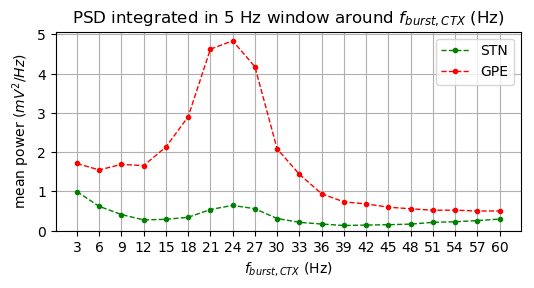

In [39]:
f_bands = [(f-2.5, f+2.5) for f in sweep_vals]
psd_integrated_summary(('STN', 'GPE.proto'), f_bands, Pmax=None,
                       cmap='Set2', export=True,
                       title='PSD integrated in 5 Hz window around ' + sweep_var_legend)

#### STN ranges

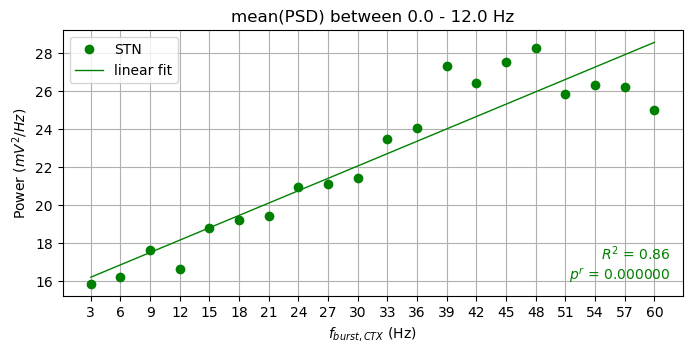

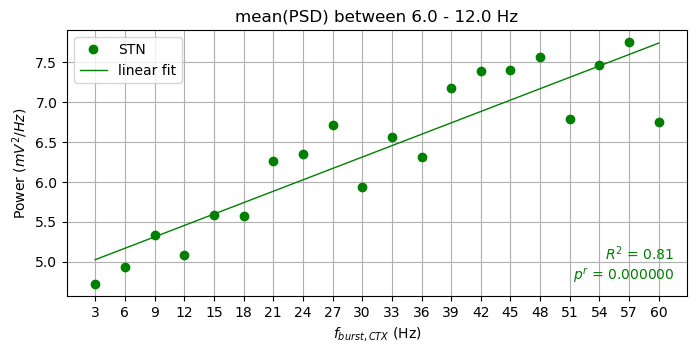

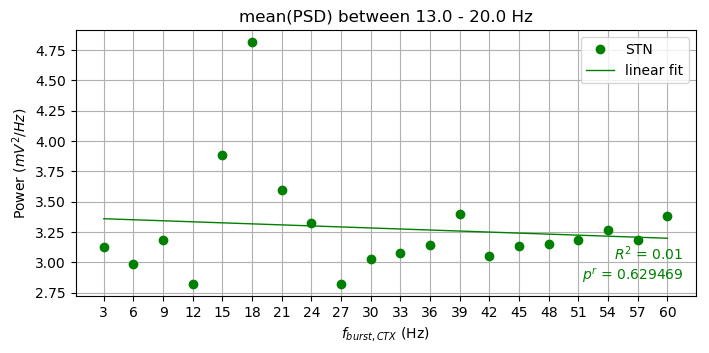

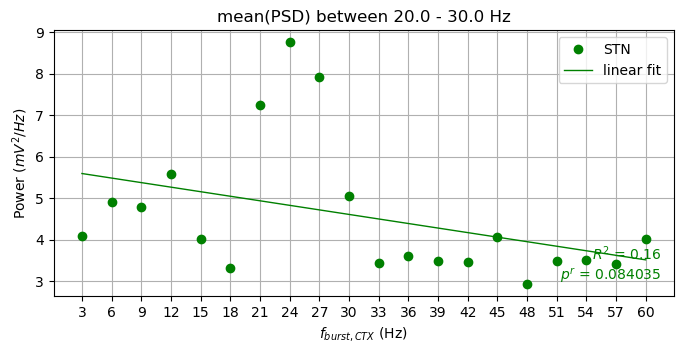

In [28]:
psd_power_integrated('STN', [0.,12.], detailed=False)
psd_power_integrated('STN', [6.,12.], detailed=False)
psd_power_integrated('STN', [13., 20.], detailed=False)
psd_power_integrated('STN', [20.,30.], detailed=False)

#### GPE ranges

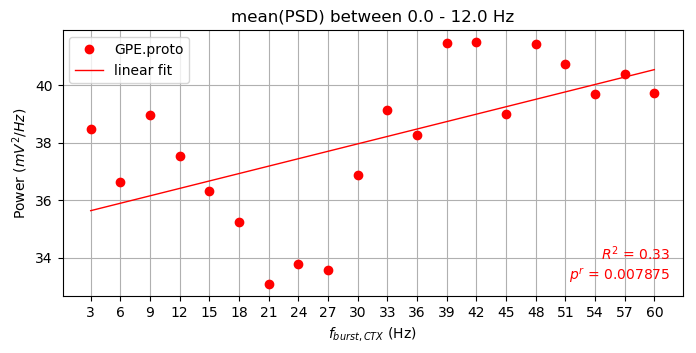

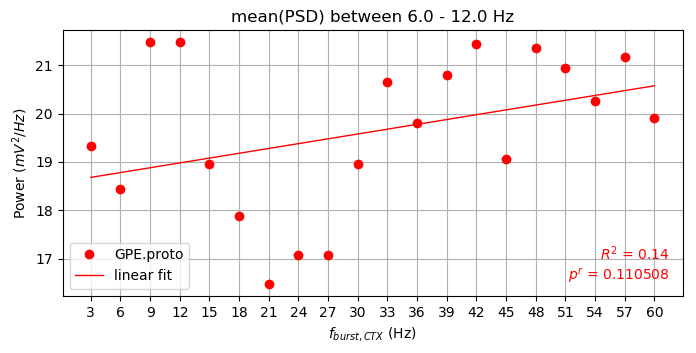

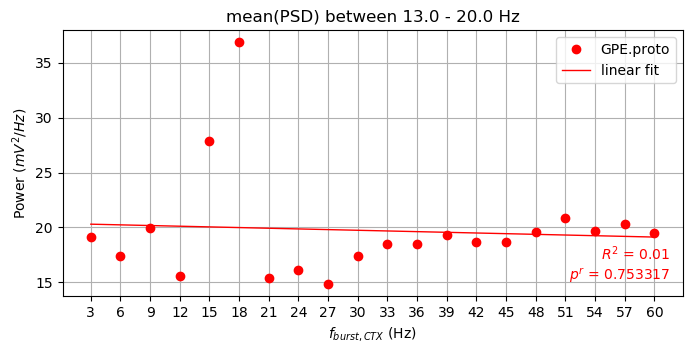

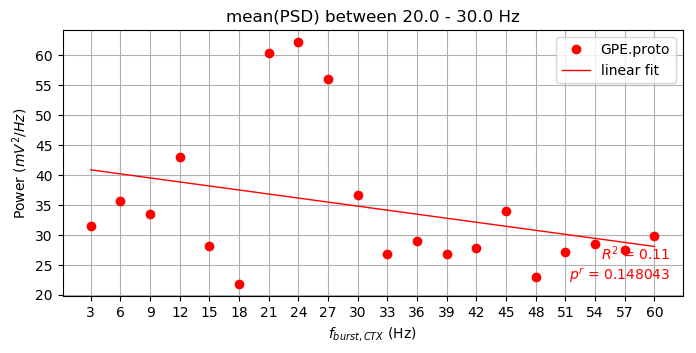

In [29]:
psd_power_integrated('GPE.proto', [0.,12.], detailed=False)
psd_power_integrated('GPE.proto', [6.,12.], detailed=False)
psd_power_integrated('GPE.proto', [13., 20.], detailed=False)
psd_power_integrated('GPE.proto', [20.,30.], detailed=False)

#### peak power

Sum PSD power in frequency bins around the peak.

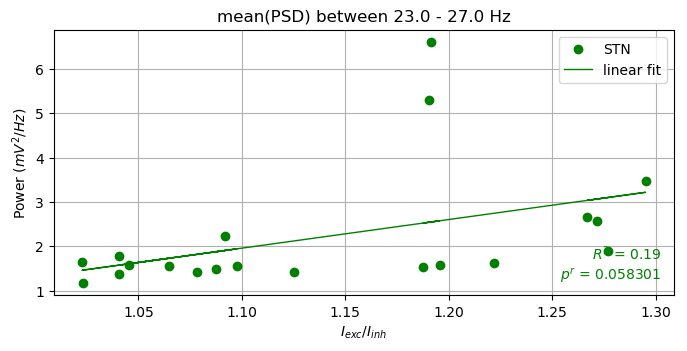

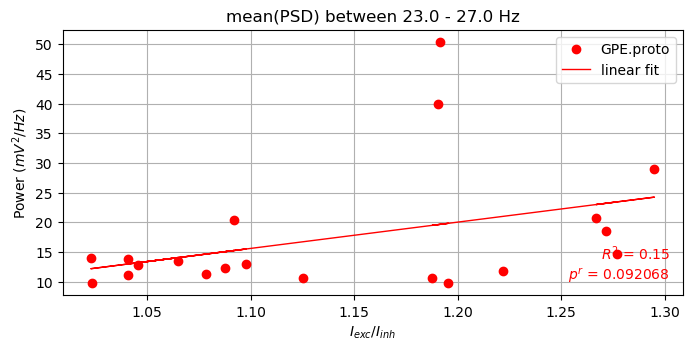

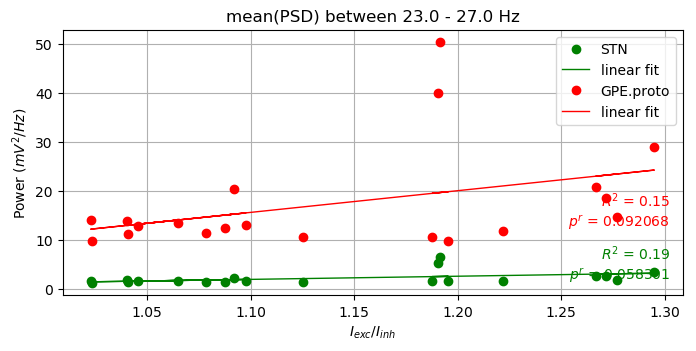

In [30]:
# SETPARAM: applied frequency of oscillatory bursts
f_burst = 25.0
f_band = [f_burst-2, f_burst+2]

# Use STN Iexc/Iinh ratio as independent variable
x = np.array([analysis_results[val]['I_exc_inh_ratio']['STN'] for val in sweep_vals])
x_label = '$I_{exc} / I_{inh}$'

# Plot linear regression of sum(PSD) vs Iexc/Iinh
psd_power_integrated('STN', f_band, detailed=False,
                     independent='custom', x=x, x_label=x_label)

psd_power_integrated('GPE.proto', f_band, detailed=False,
                     independent='custom', x=x, x_label=x_label)

psd_power_integrated(('STN', 'GPE.proto'), f_band, detailed=False,
                     independent='custom', x=x, x_label=x_label)

### PSD peak frequency

Find frequency of largest peak within Beta range.

In [31]:
def compare_Pmax_frequency(sig_labels, fband):
    """
    Find frequency of largest peak within Beta range.
    """
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title('frequency of Pmax in {} - {} Hz'.format(fband[0], fband[1]))
    
    sweep_vals = np.array(sorted(analysis_results.keys()))
    
    colors = 'bgcm'
    for i, sig_label in enumerate(sig_labels):
        freqs_Pmax = []
        for sweep_value in sweep_vals:
            f, Pxx = analysis_results[sweep_value]['PSD'][sig_label]
            
            # Calculate frequency of Pmax
            freqs = f.magnitude
            mask1 = (freqs >= fband[0]) & (freqs <= fband[1])
            mask2 = np.isclose(freqs, fband[0], atol=0.1) | np.isclose(freqs, fband[1], atol=0.1)
            fband_mask = mask1 | mask2
            Pxx_fband = Pxx[fband_mask]
            freqs_fband = freqs[fband_mask]
            f_pmax = freqs_fband[Pxx_fband == Pxx_fband.max()][0]
            freqs_Pmax.append(f_pmax)
        
        # Plot frequencies
        ax.plot(sweep_vals, freqs_Pmax, '-', 
                color=get_pop_color(sig_label[:-3]), 
                label="$f_{Pmax}$" + " ({sig})".format(sig=sig_label))
        ax.plot(sweep_vals, freqs_Pmax, 'r+')

    ax.set_xticks(sweep_vals)
    ax.set_ylabel('frequency (Hz)')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.legend()
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

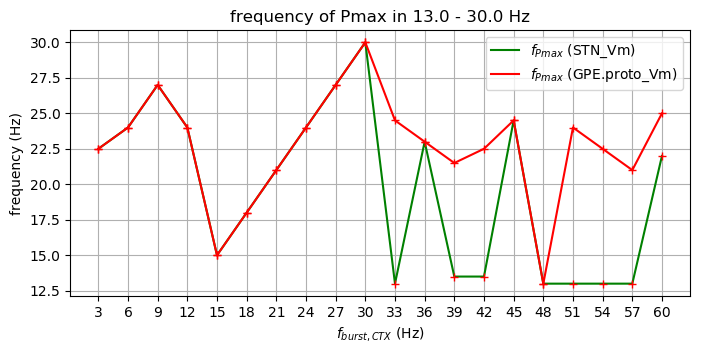

In [32]:
compare_Pmax_frequency(('STN_Vm', 'GPE.proto_Vm'), (13., 30.))

### Spectrogram peaks

Note that this might give a different picture than comparing simulations with PSD alone: a simulation with periodic synchronization may have higher transient peaks, whereas the PSD (average over time) is lower.

In [ ]:
# (freqs[0:int(50/df)], t, Sxx[:,0:int(50/df)])
# Syy = Sxx[:, int(5000.0/t_res):]

# set temporal resolution of PSD from value in synchrony_analysis_auto.ipynb
# t_res = 20.0 # ms

def compare_max_spectrogram(sig_label, band=(4.0, 30.0), t_start=5000.0):
    """
    Plot magnitude of largest spectrogram peak
    """
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sweep_vals = np.array(sorted(analysis_results.keys()))
    sweep_power = []
    for i, sweep_value in enumerate(sweep_vals):
        results = analysis_results[sweep_value]
        freqs, t, Sxx = results['spectrogram'][sig_label]
        # only look at power in sub-band
        df = freqs[1] - freqs[0]
        f_slice = np.s_[int(band[0]/df):(int(band[1]/df)+1)]
        # first 5000 ms already cut when saving
        # dt = t[1] - t[0]
        # t_slice = np.s_[int(t_start/dt):]
        t_slice = np.s_[:]
        S_max = Sxx[f_slice, t_slice].max()
        sweep_power.append(S_max)
    
    ax.plot(sweep_vals, sweep_power, '-')
    ax.plot(sweep_vals, sweep_power, 'r+')
    # ax.set_xticks(np.arange(0,5*(sweep_vals.max()//5+1),5), minor=False)
    # ax.set_xticks(np.arange(0,1*(sweep_vals.max()//1+1),1), minor=True)
    # ax.set_xlim((0, 50))
    ax.set_ylim((0, 1.1*max(sweep_power)))
    ax.set_ylabel('Power (mV^2/Hz)')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.set_title('Spectrogram max peak ({})'.format(sig_label))
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

In [ ]:
# compare_max_spectrogram('STN_Vm')
# compare_max_spectrogram('GPE_Vm')

## 1B: Burst Metrics

In [33]:
def gather_metrics(all_cell_metrics, metric):
    """
    Gather burst metric from all cells into a list
    """
    if isinstance(all_cell_metrics[0][metric], float):
        map_func = lambda x,y: x + [y]
    else:
        map_func = lambda x,y: x + y
    all_cell_vals = reduce(map_func, (cell_metrics[metric] for cell_metrics in all_cell_metrics), [])
    return all_cell_vals


def boxplots_burst_metrics(pop_label, metric_names=None, export_metrics=None):
    """
    Compare burst metrics for same population across sweep values
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if metric_names == None:
        metric_names = analysis_results[sweep_vals[0]]['burst_metrics'][pop_label][0].keys()
    
    sweep_metrics = {}
    for metric_name in metric_names:
        for i, sweep_value in enumerate(sweep_vals):
            cell_metrics = analysis_results[sweep_value]['burst_metrics'][pop_label]
            all_cell_vals = gather_metrics(cell_metrics, metric_name)
            sweep_metrics.setdefault(metric_name, []).append(all_cell_vals)
    
        # Plot boxplots
        fig, ax = plt.subplots(figsize=(ax_width, ax_height))
        ax.set_title('{} {}'.format(pop_label, metric_name))
        bp = ax.boxplot(sweep_metrics[metric_name], 0, 'g+')
        ax.set_xticklabels(sweep_vals)
        ax.set_ylim((0, ax.get_ylim()[1]))
        ax.set_ylabel(metric_name)
        ax.set_xlabel(sweep_var_legend)
        ax.grid(True, which='major', axis='y')
        fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
        
        # Save figure
        if (export_figs and (export_metrics is not None) 
                        and (metric_name in export_metrics)):
            fname = '{}_{}'.format(metric_name, pop_label)
            save_figure(fname, fig=fig)


def regression_burst_metrics(pop_label, metric_names=None, detailed=True, export_metrics=None):
    """
    Linear regression of burst metrics vs sweep variable.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if metric_names == None:
        metric_names = analysis_results[sweep_vals[0]]['burst_metrics'][pop_label][0].keys()
    
    sweep_metrics = {}
    for metric_name in metric_names:
        for i, sweep_value in enumerate(sweep_vals):
            cell_metrics = analysis_results[sweep_value]['burst_metrics'][pop_label]
            all_cell_vals = gather_metrics(cell_metrics, metric_name)
            sweep_metrics.setdefault(metric_name, []).append(all_cell_vals)
        
        # Linear regression
        x = sweep_vals
        y = [np.median(mvals) for mvals in sweep_metrics[metric_name]]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        
        # Detailed linear regression
        if detailed:
            data = pandas.DataFrame({'x': x, metric_name: y})
            model = ols("{} ~ {}".format(metric_name, 'x'), data).fit()
            print(model.summary()) # summary2()
        
        fig, ax = plt.subplots(figsize=(ax_width, ax_height))
        ax.set_title('{} {}'.format(pop_label, metric_name))
        ax.set_xticks(sweep_vals)
        ax.plot(x, y, 'o', color='g', label='original data')
        ax.plot(x, intercept + slope*x, 'k--', label='linear fit')
        ax.set_ylabel(metric_name)
        ax.set_xlabel(sweep_var_legend)
        ax.grid(True)
        ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
                transform=ax.transAxes, ha='right')
        fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
        
        # Save figure
        if (export_figs and (export_metrics is not None) 
                        and (metric_name in export_metrics)):
            fname = '{}_{}'.format(metric_name, pop_label)
            save_figure(fname, fig=fig)
            

### Summary of burst metrics

In [34]:
def summarize_burst_metrics(pop_label, metric_names,
                            axsize=(ax_width, ax_height), export=False):
    """
    Plot multiple burst metrics (median across cells) in single figure with different y-axes.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    
    fig, ax1 = plt.subplots()
    axes = [ax1] + [ax1.twinx() for m in metric_names[1:]]
    
    sweep_metrics = {}
    for i_metric, metric_name in enumerate(metric_names):
        for i, sweep_value in enumerate(sweep_vals):
            cell_metrics = analysis_results[sweep_value]['burst_metrics'][pop_label]
            all_cell_vals = gather_metrics(cell_metrics, metric_name)
            sweep_metrics.setdefault(metric_name, []).append(all_cell_vals)
        
        # Linear regression
        x = sweep_vals
        y = [np.median(mvals) for mvals in sweep_metrics[metric_name]]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        
        # Plot metric
        ax = axes[i_metric]
        act, = ax.plot(x, y, '--', marker='.', linewidth=1, markersize=6,
                       color=style_color_cycle[i_metric], label='original data')
        # ax.plot(x, intercept + slope*x, 'k--', label='linear fit')
        
        ax.set_ylabel(metric_name, color=act.get_color())
        ax.tick_params(axis='y', colors=act.get_color(), size=4, width=1.5)
        # ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
        #         transform=ax.transAxes, ha='right')
        
        if i_metric == 0:
            ax.set_xticks(sweep_vals)
            ax.set_xlabel(sweep_var_legend)
            ax.grid(True)
        elif i_metric == 2:
            offset_show_twin_yax(ax, offset=1.12)
            
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    set_axes_size(axsize[0], axsize[1], ax1)

    # Save figure
    if export_figs and export:
        fname = 'burst-metrics_{}_{}'.format(sweep_var_name, pop_label)
        save_figure(fname, fig=fig)

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/burst-metrics_f-burst-ctx_STN.pdf


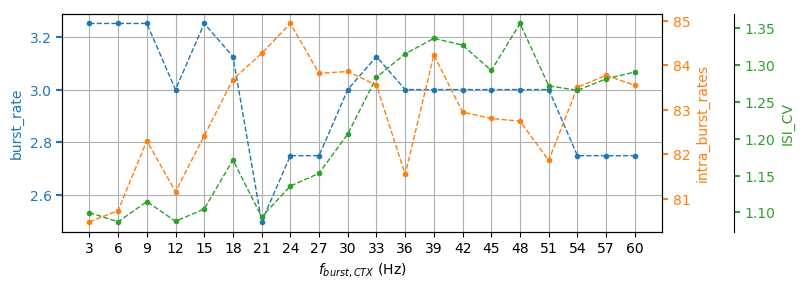

In [35]:
metrics = ['burst_rate', 'intra_burst_rates', 'ISI_CV']
summarize_burst_metrics('STN', metrics, axsize=(ax_width, ax_width/2.75), export=True)

### STN Boxplots of Burst Metrics

One boxplot per sweep variable.

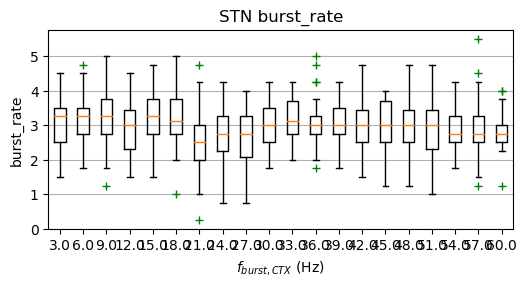

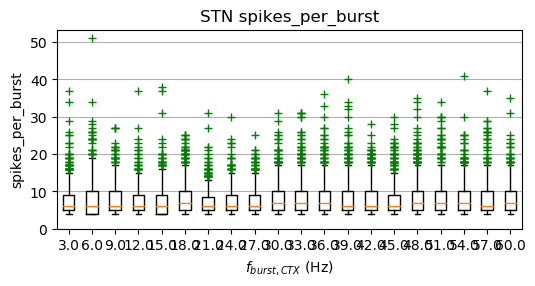

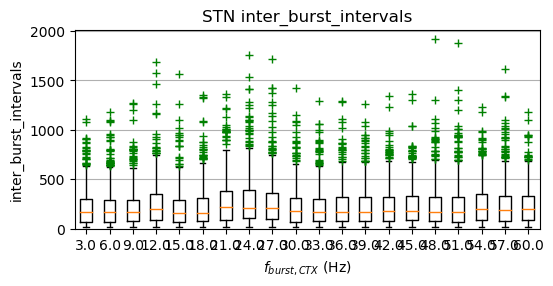

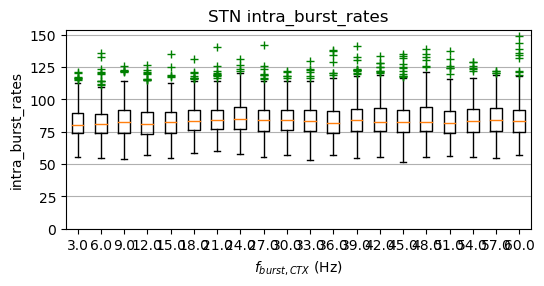

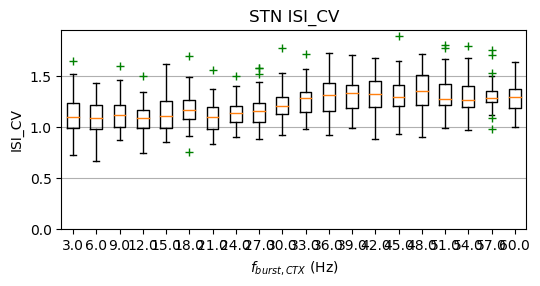

In [36]:
boxplots_burst_metrics('STN')

### GPE Boxplots of Burst Metrics

One boxplot per sweep variable.

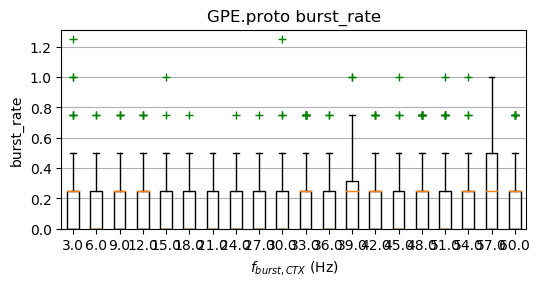

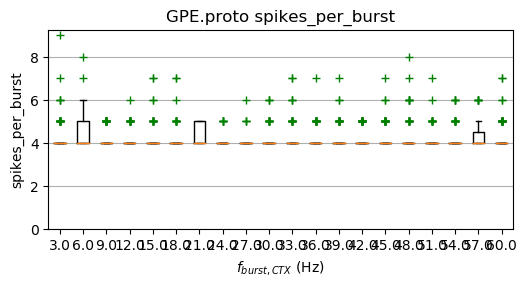

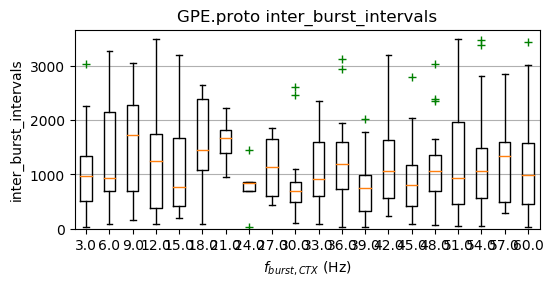

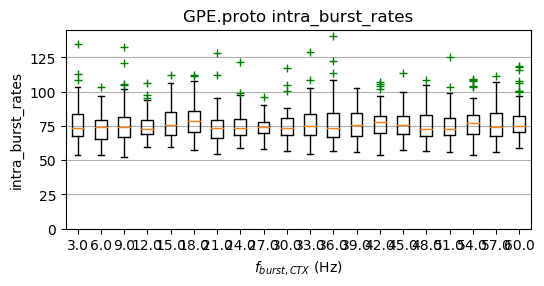

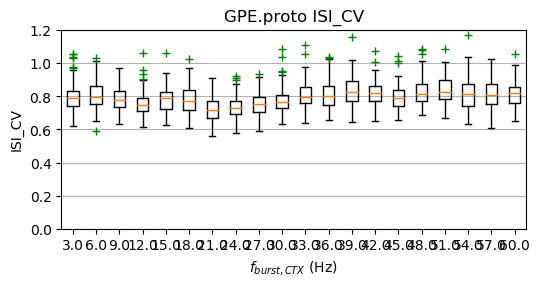

In [37]:
boxplots_burst_metrics('GPE.proto')

### [alt] STN Regression Burst metrics

Linear regression & Pearson correlation.

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/ISI_CV_STN.pdf


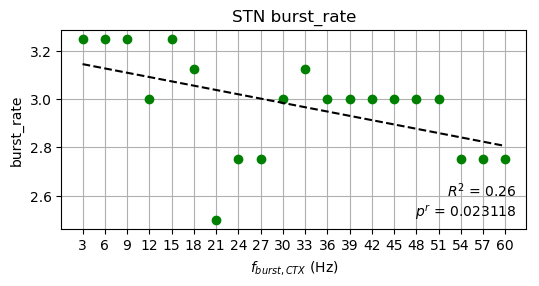

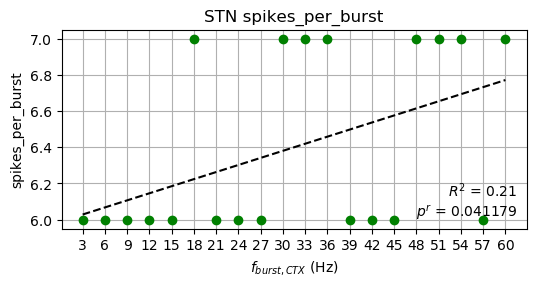

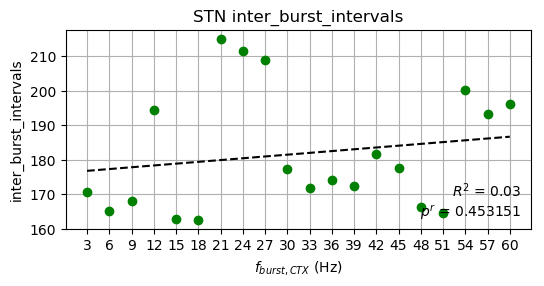

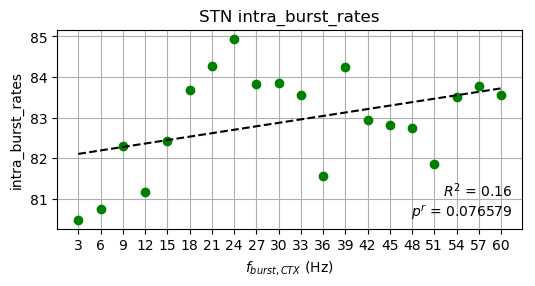

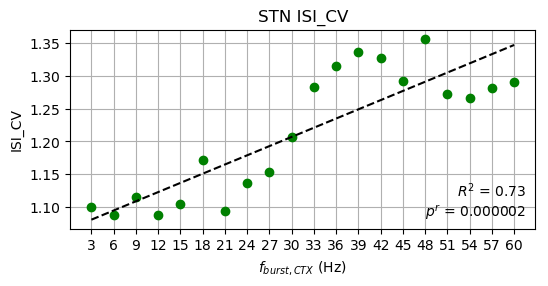

In [38]:
regression_burst_metrics('STN', detailed=False, export_metrics='ISI_CV')

### [alt] GPE Regression Burst metrics

Linear regression & Pearson correlation.

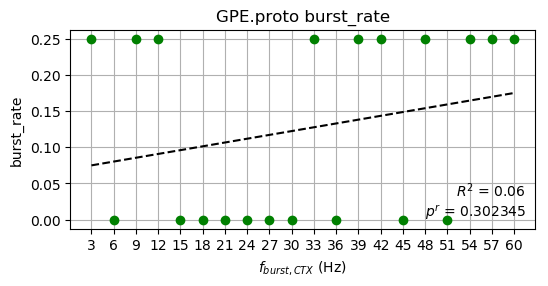

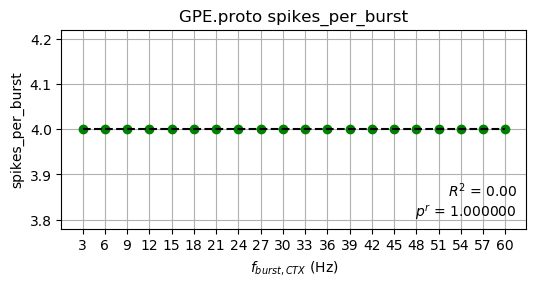

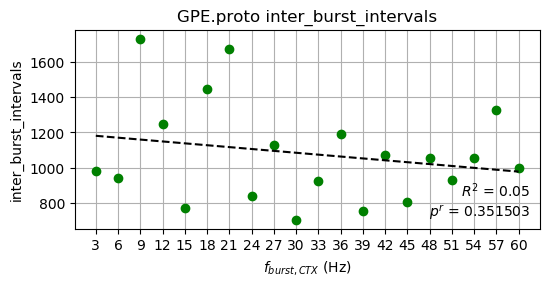

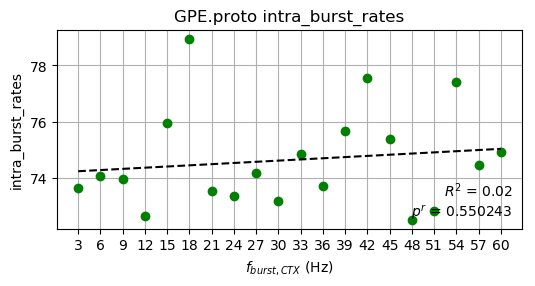

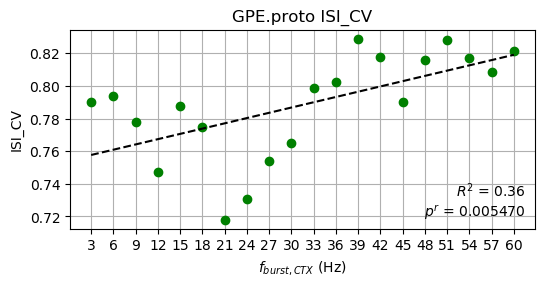

In [39]:
regression_burst_metrics('GPE.proto', detailed=False)

## 1C: Population Synchronization

In [40]:
def composite_coherence_integrated(pops, f_band, detailed=True, Cxy_max=None):
    """
    Linear regression of integrated composite coherence.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if len(pops) > 1:
        pop_a, pop_b = pops
        key = '{}-{}'.format(pop_a, pop_b)
    else:
        key = pops[0]
    
    all_Cxy_sum = []
    for i, sweep_value in enumerate(sweep_vals):
        coherence = analysis_results[sweep_value]['coherence_composite'][key]
        f, Cxy = coherence[0], coherence[1]
        Csum = integrate_subband(f, Cxy, f_band)
        all_Cxy_sum.append(Csum)
    
    # Linear regression
    metric_name = 'Cxy_sum'
    x = sweep_vals
    y = np.array(all_Cxy_sum) / (f_band[1] - f_band[0])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

    # Detailed linear regression
    if detailed:
        data = pandas.DataFrame({'x': x, metric_name: y})
        model = ols("{} ~ {}".format(metric_name, 'x'), data).fit()
        print(model.summary()) # summary2()
    
    # Save results
    sweep_meta_results.setdefault('comp_coherence_integrated', {})\
                      .setdefault(key, {})[tuple(f_band)] = y
    
    # Plot results
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    ax.set_title('{} Composite spiketrain coherence ({} - {} Hz)'.format(key, f_band[0], f_band[1]))
    ax.plot(x, y, 'o', color='g', label='original data')
    ax.plot(x, intercept + slope*x, 'k--', label='linear fit')
    if Cxy_max is None:
        ax.set_ylim((0, 1.1 * y.max()))
    else:
        ax.set_ylim((0, Cxy_max))
    ax.set_xticks(sweep_vals)
    ax.set_ylabel('Cxy / Hz')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
            transform=ax.transAxes, ha='right')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

In [41]:
def sample_cmap(cmap, sample, vmin, vmax):
    # cNorm  = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    # scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
    # return scalarMap.to_rgba(sample)
    return cmap(min(vmax-vmin, max(0, sample-vmin)) / (vmax - vmin))

def composite_coherence_multiband(pops, bands, Cxy_max=None, cmap='Set2', export=False):
    """
    Composite spiketrain coherence integrated in different frequency bands.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    if len(pops) > 1:
        pop_a, pop_b = pops
        key = '{}-{}'.format(pop_a, pop_b)
    else:
        key = pops[0]
    
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    ax.set_title('{} Composite spiketrain coherence'.format(key))
    cmap = plt.get_cmap(cmap)
    
    # Integrate coherence in all bands, for every sweep value
    bands_Cxy = {}
    for f_band in bands:
        bands_Cxy[f_band] = Cxy_sum = []
        for i, sweep_value in enumerate(sweep_vals):
            coherence = analysis_results[sweep_value]['coherence_composite'][key]
            f, Cxy = coherence[0], coherence[1]
            bands_Cxy[f_band].append(integrate_subband(f, Cxy, f_band))
    
        x = sweep_vals
        y = np.array(Cxy_sum) / (f_band[1] - f_band[0])
        
        sample_pt = (f_band[1] + f_band[0]) / 2.0
        line_color = sample_cmap(cmap, sample_pt, 0.0, 33.0)
        line_label = '{:>2.0f} - {:>2.0f} Hz'.format(*f_band)
        ax.plot(x, y, '--', marker='.', linewidth=1, markersize=6, label=line_label) # color=linecolor
    
    # Axes and legend
    if Cxy_max is None:
        ax.set_ylim((0, ax.get_ylim()[1]))
    else:
        ax.set_ylim((0, Cxy_max))
    ax.set_xticks(sweep_vals)
    ax.set_ylabel('Cxy / Hz')
    ax.set_xlabel(sweep_var_legend)
    ax.legend()
    ax.grid(True, axis='y')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    if export_figs and export:
        fname = 'comp-spk-coherence_{}'.format(key)
        save_figure(fname, fig=fig)

### STN-GPe Composite Coherence

Integrated coherence in 13-30 Hz frequency band.

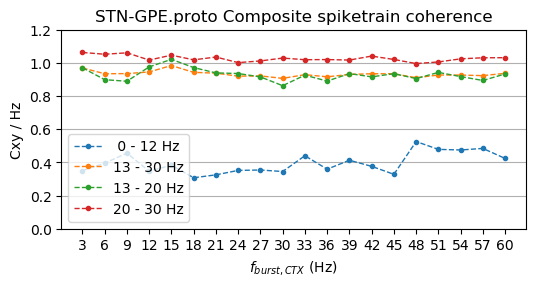

In [42]:
# Multiple frequency bands on single figure
composite_coherence_multiband(('STN', 'GPE.proto'),
                              bands=[(0.,12.), (13., 30.), (13.,20.), (20.,30.)],
                              Cxy_max=1.2, export=False)

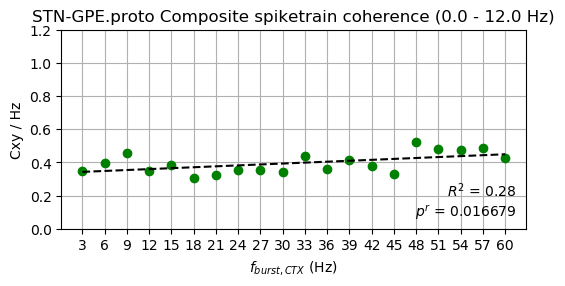

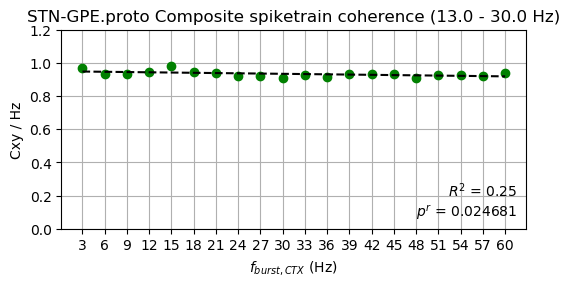

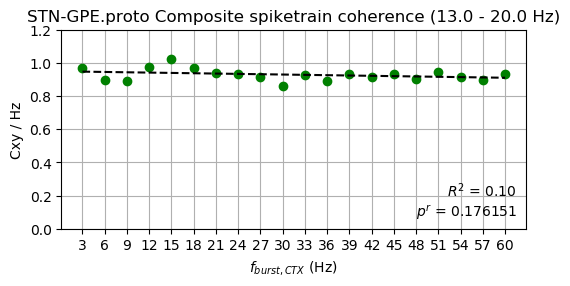

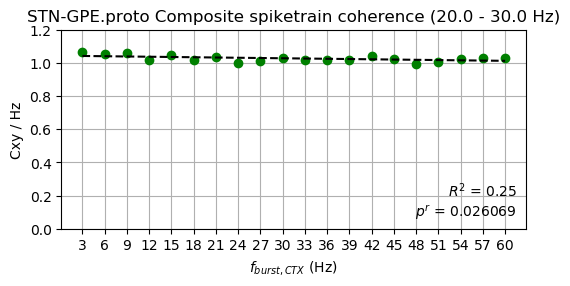

In [43]:
# composite_coherence_integrated('STN', 'GPE.proto', [13.,30.], detailed=False)
composite_coherence_integrated(('STN', 'GPE.proto'), [0.,12.],  Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN', 'GPE.proto'), [13.,30.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN', 'GPE.proto'), [13.,20.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN', 'GPE.proto'), [20.,30.], Cxy_max=1.2, detailed=False)

### STN Composite Coherence

Integrated coherence in 13-30 Hz frequency band.

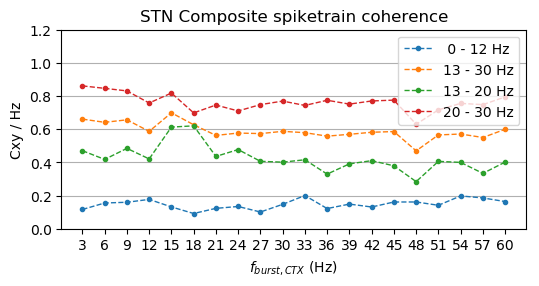

In [44]:
# Multiple frequency bands on single figure
composite_coherence_multiband(('STN',),
                              bands=[(0.,12.), (13., 30.), (13.,20.), (20.,30.)],
                              Cxy_max=1.2, export=False)

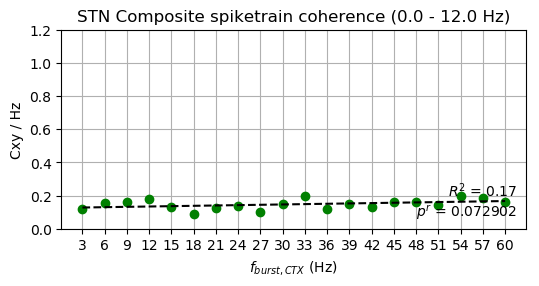

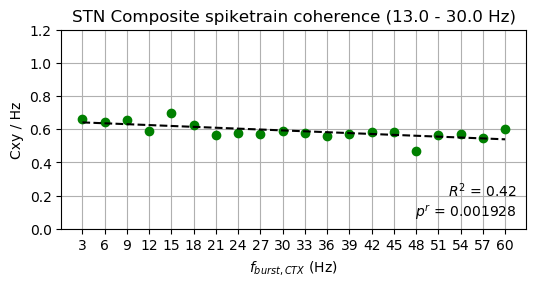

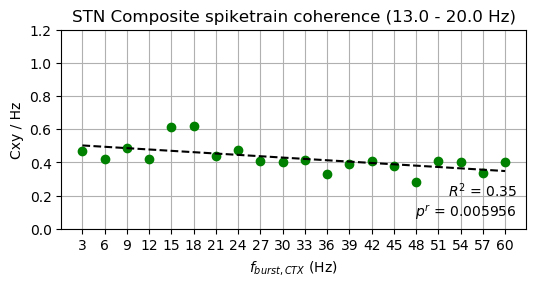

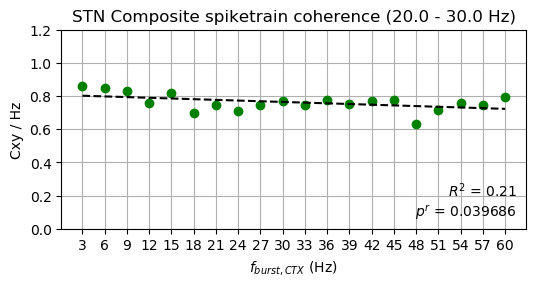

In [45]:
# composite_coherence_integrated('STN', 'GPE.proto', [13.,30.], detailed=False)
composite_coherence_integrated(('STN',), [0.,12.],  Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN',), [13.,30.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN',), [13.,20.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('STN',), [20.,30.], Cxy_max=1.2, detailed=False)

### GPE Composite Coherence

Integrated coherence in 13-30 Hz frequency band.

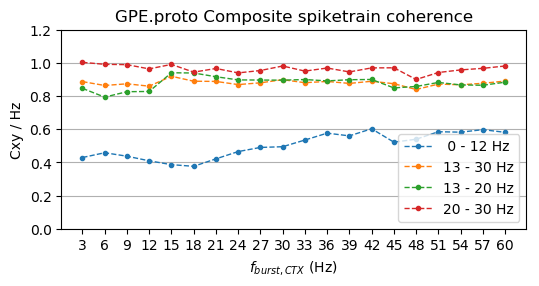

In [46]:
# Multiple frequency bands on single figure
composite_coherence_multiband(('GPE.proto',),
                              bands=[(0.,12.), (13., 30.), (13.,20.), (20.,30.)],
                              Cxy_max=1.2, export=False)

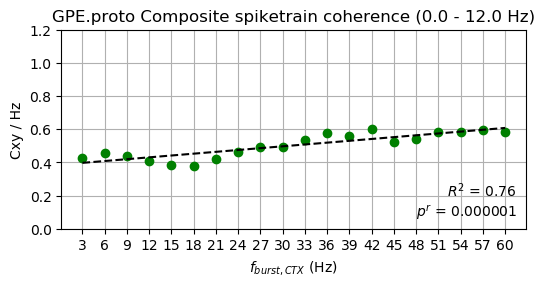

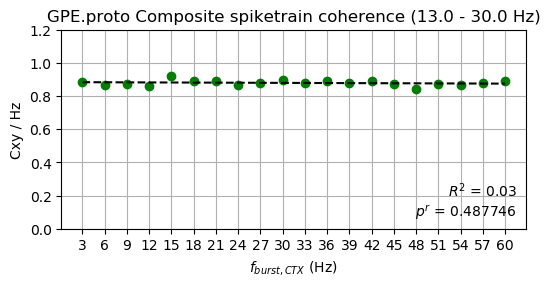

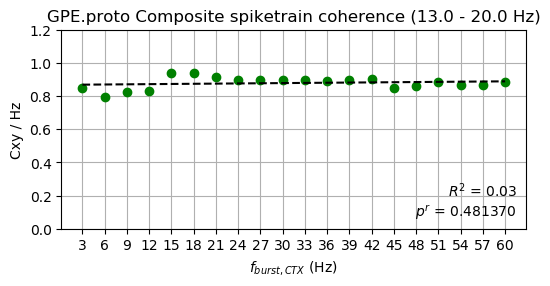

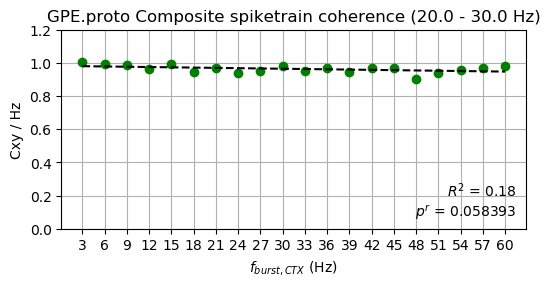

In [47]:
# composite_coherence_integrated('STN', 'GPE.proto', [13.,30.], detailed=False)
composite_coherence_integrated(('GPE.proto',), [0.,12.],  Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('GPE.proto',), [13.,30.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('GPE.proto',), [13.,20.], Cxy_max=1.2, detailed=False)
composite_coherence_integrated(('GPE.proto',), [20.,30.], Cxy_max=1.2, detailed=False)

### [alt] STN Covariance Complexity

In [48]:
def compare_covariance_complexity(sig_label, f_band=None, detailed=False, ymax=None):
    """
    Compare distribution of Morgera-index values for time segments 
    in simulation.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    M_datasets = []
    M_intervals = []
    for i, sweep_value in enumerate(sweep_vals):
        fbands_M = analysis_results[sweep_value]['Morgera_index'][sig_label]
        if isinstance(fbands_M, dict):
            # Morgera index was computed for several frequency bands
            if f_band:
                t, M = fbands_M[f_band]
            else:
                t, M = fbands_M[(5, 200)]
        else:
            # Morgera index was only computed in default band (5, 200) Hz
            if f_band:
                raise ValueError('Morgera index was only computed in f = (5, 200)')
            t, M = fbands_M
        M_datasets.append(M)
        M_intervals.append(t)

    M_array = np.array(M_datasets)
    mean_M = np.mean(M_array, axis=1)
    std_M = np.std(M_array, axis=1)
    med_M = np.median(M_array, axis=1)
    ival_width = M_intervals[0][0][1] - M_intervals[0][0][0]
    
    # Plot boxplots
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    ax.set_title('Covariance complexity over {} ms intervals'.format(ival_width))
    bp = ax.boxplot(M_datasets, 0, 'g+')
    ax.set_xticklabels(sweep_vals)
    # ax.set_ylim((0, 1))
    ax.set_ylabel('M (0-1)')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True, which='major', axis='y')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    # Linear regression
    metric_name = 'M'
    x = sweep_vals
    y = med_M
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

    # Detailed linear regression
    if detailed:
        data = pandas.DataFrame({'x': x, metric_name: y})
        model = ols("{} ~ {}".format(metric_name, 'x'), data).fit()
        print(model.summary()) # summary2()

    # Plot linear regression
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    ax.set_title('Median covariance complexity over {} ms intervals'.format(ival_width))
    ax.plot(x, y, 'o', color='g', label='original data')
    ax.plot(x, intercept + slope*x, 'k--', label='linear fit')
    if ymax:
        ax.set_ylim((0, ymax))
    ax.set_xticks(sweep_vals)
    ax.set_ylabel('M (0-1)')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
            transform=ax.transAxes, ha='right')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

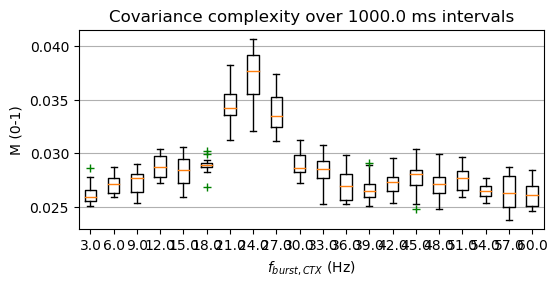

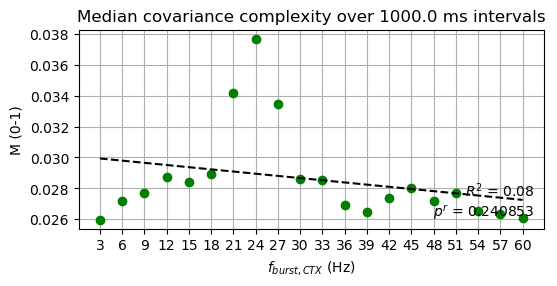

In [49]:
compare_covariance_complexity('STN_Vm')

### [alt] GPE Covariance Complexity

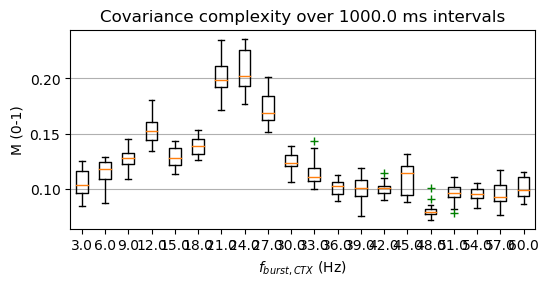

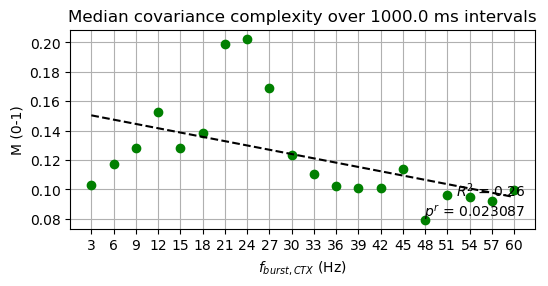

In [50]:
compare_covariance_complexity('GPE.proto_Vm')

## 1C : Phase Locking Strength

Phase locking to input burst frequency. 

**Guidelines**: Notebooks must be executed with time segment containing Beta inputs and correct filtering settings (around Beta frequency).

In [31]:
def compare_phases_polar(pop_label):
    """
    Compare population phase vectors across simulations (sweep values)
    by plotting a polar plot for each simulation.
    """
    fig = plt.figure(figsize=(0.75*page_width, 0.75*page_width))
    fig.suptitle('Mean angle and vector length of {} neurons'.format(pop_label))
    # fig.suptitle(sweep_var_legend, color='blue', x=0.5, y=0.02)
    
    nplot = len(sweep_vals)
    ncol = 3
    nrow = int(np.ceil(float(nplot) / ncol))
    
    all_cell_vecs = [analysis_results[val]['cell_phase_vecs'][pop_label] for val in sweep_vals]
    all_pop_vecs = [analysis_results[val]['pop_phase_vecs'][pop_label] for val in sweep_vals]
    
    # Store in dictionary for pickling
    sweep_meta_results.setdefault('pop_phase_vecs', {})[pop] = np.array(all_pop_vecs)
    
    for i, sweep_val in enumerate(sweep_vals):
        cell_vecs = all_cell_vecs[i]
        pop_vec = all_pop_vecs[i]
        
        vec_angs = np.angle(cell_vecs)
        vec_lens = np.abs(cell_vecs)
        rmax = 0.5 # (vec_lens.max() // 0.1 + 1) * 0.1
        
        ax = fig.add_subplot(nrow, ncol, i+1, projection='polar')
        ax.set_title('{}'.format(sweep_val), color='blue', loc='left', ha='left')
        
        ax.vlines(vec_angs, 0, vec_lens, color='g', linewidth=1, snap=True)
        ax.vlines(np.angle(pop_vec), 0, np.abs(pop_vec), color='r', linewidth=3)
        ax.plot(vec_angs, np.zeros_like(vec_angs)+rmax, 'go', markersize=5)

        ax.grid(True)
        ax.set_rticks(np.arange(0.1, 1.1, 0.1)) # less radial ticks
        ax.set_rmax(rmax)
        # ax.set_rlabel_position(-90.0)  # Move radial labels away from plotted line


def regress_vector_length(pop_label, detailed=True):
    """
    Linear regression of population vector length.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    all_pop_vecs = np.array([analysis_results[val]['pop_phase_vecs'][pop_label] for val in sweep_vals])
    all_vec_len = np.abs(all_pop_vecs)
    
    # Linear regression
    metric_name = 'vec_len'
    x = sweep_vals
    y = all_vec_len
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

    # Detailed linear regression
    if detailed:
        data = pandas.DataFrame({'x': x, metric_name: y})
        model = ols("{} ~ {}".format(metric_name, 'x'), data).fit()
        print(model.summary()) # summary2()

    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    ax.set_title('{} phase vector length'.format(pop_label))
    ax.plot(x, y, 'o', color='g', label='original data')
    ax.plot(x, intercept + slope*x, 'k--', label='linear fit')
    ax.set_xticks(sweep_vals)
    ax.set_ylabel('length (0-1)')
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
            transform=ax.transAxes, ha='right')
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

    
def vector_angle_difference(pop_a, pop_b, axsize=(ax_width, ax_height), export=False,
                            ang_color='blue', len_color='orange',
                            ang_loc='lower right', len_loc='lower left',
                            color_using_axis=True):
    """
    Plot difference in angle of the population vector.
    """
    sweep_vals = np.array(sorted(analysis_results.keys()))
    pops = pop_a, pop_b
    
    pops_vecs = [np.array([analysis_results[val]['pop_phase_vecs'][pop] for val in sweep_vals])
                    for pop in pops]
    pops_angles = [np.angle(vecs, deg=False) for vecs in pops_vecs]
    pops_veclens = [np.abs(vecs) for vecs in pops_vecs]
    pop_angles_diffs = np.unwrap((pops_angles[1] - pops_angles[0]) % (2*np.pi)) * 180/np.pi
     
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_title('{}-{} mean phase difference'.format(pop_b, pop_a))
    
    # Plot angle difference on left axis
    act1, = ax2.plot(sweep_vals, pop_angles_diffs, '--', marker='^', linewidth=1, markersize=6,
                    color=ang_color, label='$\Delta\phi$')
    
    # Axes and legend
    ax2.set_ylim((0, max(90, pop_angles_diffs.max()*1.1)))
    ax2.set_ylabel('angle (degrees)', color=ang_color)
    ax2.tick_params(axis='y', colors=ang_color, size=4, width=1.5)
    ax2.legend(loc=ang_loc)
    
    # Plot vector lengths on right axis
    markers = 'v', 's', '^', '+', 'x'
    for i, pop in enumerate(pops):
        pop_color = get_pop_color(pop)
        pop_label = pop.split('.')[0]
        marker_color = len_color if color_using_axis else pop_color
        ax1.plot(sweep_vals, pops_veclens[i], '--', linewidth=1,
                 marker='o', markersize=4, markerfacecolor=marker_color, markeredgecolor=marker_color,
                 color=pop_color, label='|{}|'.format(pop_label)) # color=get_pop_color(pop)
    
    # Axes and legend
    ax1.set_ylabel('length (0-1)', color=len_color)
    ax1.tick_params(axis='y', colors=len_color, size=4, width=1.5)
    ax1.set_ylim((0, max(0.5, 1.1*max(lens.max() for lens in pops_veclens))))
    ax1.legend(loc=len_loc)
    
    ax1.set_xticks(sweep_vals)
    ax1.set_xlabel(sweep_var_legend)
    ax1.grid(True)
    fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel
    
    # Save figure
    set_axes_size(axsize[0], axsize[1], ax1)
    if export_figs and export:
        fname = 'vector_lengths_delta-phi_{}-{}'.format(sweep_var_name, pop_a, pop_b)
        save_figure(fname, fig=fig)

### STN Vector Length

Vector length measure: strength of phase locking to Beta input.

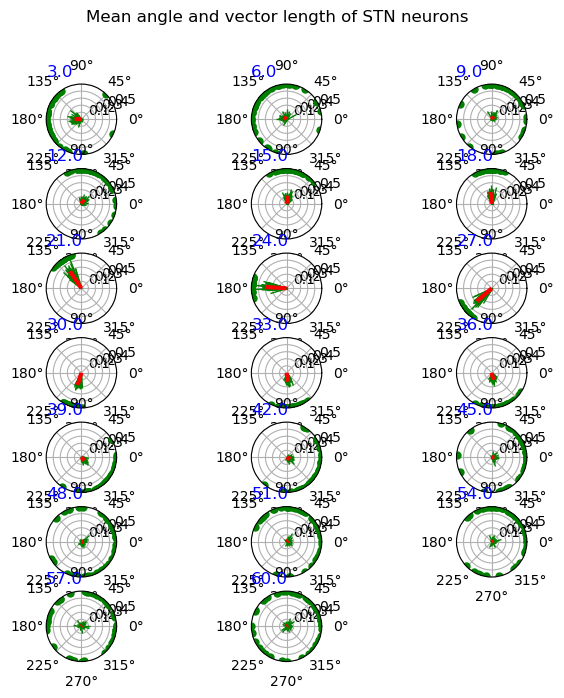

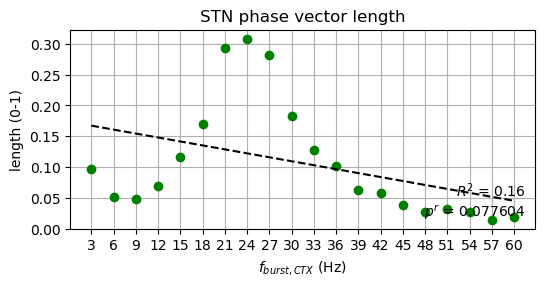

In [52]:
compare_phases_polar('STN')
regress_vector_length('STN', detailed=False)

### GPE Vector Length

Vector length measure: strength of phase locking to Beta input.

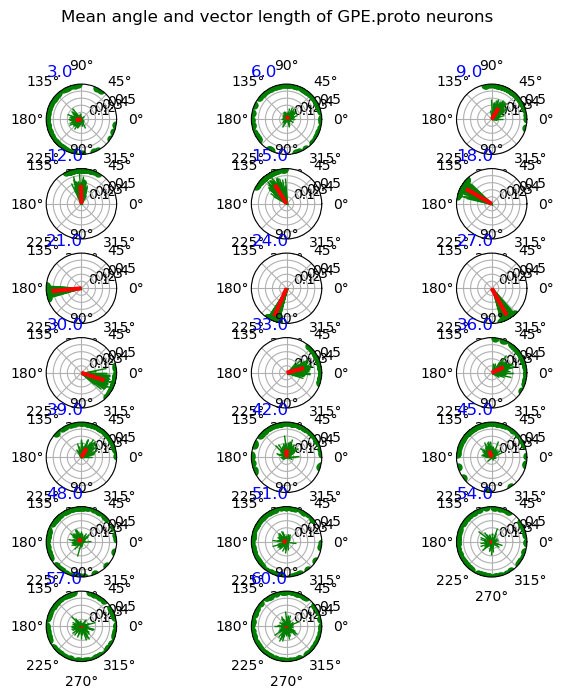

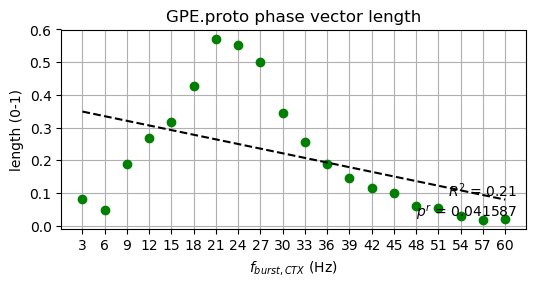

In [53]:
compare_phases_polar('GPE.proto')
regress_vector_length('GPE.proto', detailed=False)

### Angle Difference + Length

Figure saved to file /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/figs_meta-report_sweep-f-burst-ctx/vector_lengths_delta-phi_f-burst-ctx-STN.pdf


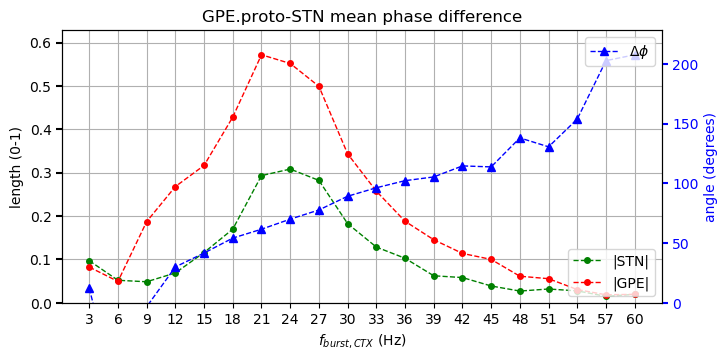

In [33]:
# TODO take population vector angle module 360, plot on one axis, plot vector length and psd power on another axis
vector_angle_difference('STN', 'GPE.proto', export=True,
                        len_color='xkcd:pumpkin orange', color_using_axis=True,
                        len_loc='lower right', ang_loc='upper right')

###  PSD peak magnitude @ f_burst
PSD peak magnitude at frequency of applied cortical bursting inputs.

In [55]:
def compare_psd_magnitude(sig_label, input_freqs):
    """
    Plot PSD magnitude at frequency of applied cortical bursting
    """
    fig, ax = plt.subplots(figsize=(ax_width, ax_height))
    sweep_vals = np.array(sorted(analysis_results.keys()))
    sweep_power = []
    for i, sweep_value in enumerate(sweep_vals):
        results = analysis_results[sweep_value]
        freqs, psd = results['PSD'][sig_label]
        freq_axis = freqs.magnitude
        f_input = input_freqs[i]
        i_entrain, = np.where(freq_axis == f_input)
        p_entrain = psd[i_entrain[0]]
        sweep_power.append(p_entrain)
    
    ax.plot(sweep_vals, sweep_power, '-')
    ax.plot(sweep_vals, sweep_power, 'r+')
    vmin, vmax = sweep_vals.min(), sweep_vals.max()
    ax.set_xticks(sweep_vals)
    # ax.set_xticks(np.arange(vmin, vmax, ticks_dx), minor=False)
    # ax.set_xlim((0, 50))
    ax.set_ylabel('Power ({})'.format(psd.units))
    ax.set_xlabel(sweep_var_legend)
    ax.grid(True)
    ax.set_title('PSD @ f_input ({})'.format(sig_label))

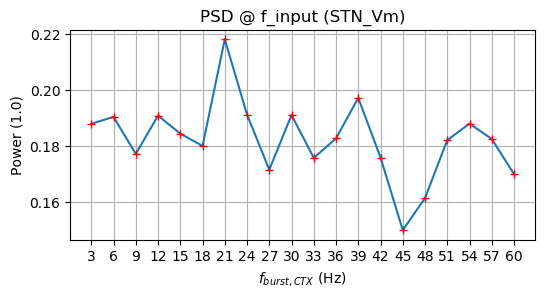

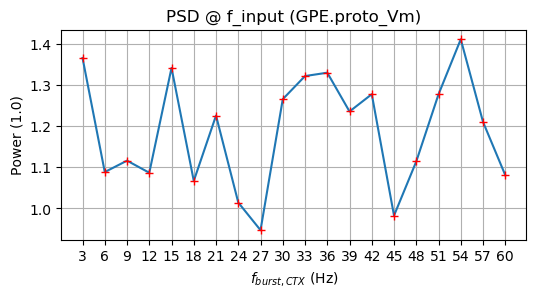

In [56]:
%%skip $without_ctx_bursting

f_inputs = [20.0 for i in range(len(analysis_results))]
compare_psd_magnitude('STN_Vm', input_freqs=f_inputs)
compare_psd_magnitude('GPE.proto_Vm', input_freqs=f_inputs)

# Compare Across Sweeps

## Settings & Functions

In [57]:
# Get pickle filenames of other sweeps
# filenames = os.listdir(meta_sweep_dir)
# pickle_paths = [os.path.join(meta_sweep_dir, f) for f in filenames if f.endswith('.pkl')]

# # Or specify paths manually
# sweeps_pickle_paths = """
# /run/media/luye/Windows7_OS/Users/lkoelman/simdata-win/LuNetStnGpe/q8c_sweep-stn-EI_gmax-ctx-stn_BURST/sweep-meta_analysis/sweep-meta_analysis_results_9.0s-13.0s_BURST-25hz_phase-from-ctx
# /run/media/luye/Windows7_OS/Users/lkoelman/simdata-win/LuNetStnGpe/q9a_disable-NR2A_sweep-gmax-ctx-stn_BURST/sweep-meta_analysis/sweep-meta_analysis_results_9.0s-13.0s_BURST-25hz.pkl
# /run/media/luye/Windows7_OS/Users/lkoelman/simdata-win/LuNetStnGpe/q9b_prune-dend_GLUR_sweep-g-ctx-stn_BURST/sweep-meta_analysis/sweep-meta_analysis_results_9.0s-13.0s_BURST-25hz.pkl
# """.strip().split()

# # Name for each sweep
# sweep_labels = ['control', 'no NR2A', 'pruned']

# # Load data for each sweep
# sweeps_meta_results = {}
# for i, fname in enumerate(sweeps_pickle_paths):
#     with open(fname, 'rb') as f:
#         pickled_data = pickle.load(f)
#     sweeps_meta_results[sweep_labels[i]] = pickled_data

In [58]:
def compare_phase_vecs_across_sweeps(pickle_filenames, meta_labels, pops, independent='EI', **kwargs):
    # Load population phase vectors for each sweep
    sweeps_phase_vecs = {}
    for i, fname in enumerate(pickle_filenames):
        with open(fname, 'rb') as f:
            pickled_data = pickle.load(f)
        sweeps_phase_vecs[meta_labels[i]] = pickled_data['pop_phase_vecs']
    
    if independent == 'sweep':
        x = sweep_vals
        x_label = sweep_var_legend
        x_ticks = sweep_vals
    elif independent == 'EI':
        x = sweep_meta_results['EI_ratio']['STN']
        x_label = 'STN E/I'
        x_ticks = kwargs.get('x_ticks', None)
    else:
        raise ValueError("Argument <independent> must be one of 'sweep', 'EI'.")
    
    # Plot on same axis, one figure per population
    for pop in pops:
        fig, ax = plt.subplots(figsize=(ax_width, ax_height))
        ax.set_title('{} population vectors'.format(pop))
        
        all_vec_lens = []
        for sweep_label in sweeps_phase_vecs.keys():
            pops_vecs = sweeps_phase_vecs[sweep_label][pop]
            pops_angles = [np.angle(vecs, deg=False) for vecs in pops_vecs]
            pops_veclens = [np.abs(vecs) for vecs in pops_vecs]
            all_vec_lens.extend(pops_veclens)
            
            # Plot vector lengths
            ax.plot(x, pops_veclens, '--', marker='.', 
                    linewidth=1, markersize=6, label=str(sweep_label))
    
        # Axes and legend
        ax.set_ylabel('length (0-1)')
        ax.set_ylim((0, kwargs.get('vmax', max(0.5, 1.1*max(lens.max() for lens in all_vec_lens)))))
        ax.legend(loc='best')

        if independent == 'sweep':
            ax.set_xticks(x_ticks)
        ax.set_xlabel(x_label)
        ax.grid(True)
        fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

        if export_figs:
            fname = 'vector-lengts_across-sweeps_{}'.format(pop)
            save_figure(fname, fig=fig, bbox_inches='tight') # bbox_extra_artists=[ax3.yaxis.label]

## Vector Length

In [59]:
# ===============================================================================
# COMMENT below during automatic execution

# Compare other sweeps to this one
# sweep_labels = ["{} Hz".format(f) for f in (20, 25, 30)]
# compare_phase_vecs_across_sweeps(sweeps_pickle_paths, sweep_labels, ('STN', 'GPE.proto'),
#                                  independent='EI', vmax=0.6)

In [60]:
def compare_psd_sum_across_sweeps(populations, f_band, independent='EI',
                                  Pmax=None, export=False, **kwargs):
    """
    Composite spiketrain coherence integrated in different frequency bands.
    """
    # One figure per population, one color per sweep
    for i_pop, pop_label in enumerate(populations):
        fig, ax = plt.subplots(figsize=(ax_width, ax_height))
        ax.set_title('{} Vm : mean power ({} - {} Hz)'.format(pop_label, *f_band))
        
        # Plot the data for each sweep on the same axis
        all_sweep_values = set()
        for sweep_label in sweeps_meta_results.keys():
            if independent == 'sweep':
                x = sweeps_meta_results[sweep_label]['sweep_values']
                all_sweep_values.update(x)
                x_label = sweep_var_legend
            elif independent == 'EI':
                x = sweeps_meta_results[sweep_label]['EI_ratio']['STN']
                x_label = 'STN E/I'
            else:
                raise ValueError("Argument <independent> must be one of 'sweep', 'EI'.")
            
            # Get y-values
            y = sweeps_meta_results[sweep_label]['PSD_integrated'][pop_label][f_band]
    
            # Plot vector lengths
            def_opts = {'marker': 'o', 'markersize': 4, 'linestyle': 'dashed', 'linewidth': 1}
            plt_opts = {opt: kwargs.get(opt, v) for opt, v in def_opts.items()}
            ax.plot(x, y, label=str(sweep_label), **plt_opts)
        
        # Axes and legend
        if Pmax is None:
            ax.set_ylim((0, ax.get_ylim()[1]))
        else:
            ax.set_ylim((0, Pmax))
        ax.set_ylabel('Power ($mV^2/Hz$)')
        if independent == 'sweep':
            ax.set_xlabel(sweep_var_legend)
            ax.set_xticks(sorted(all_sweep_values))
        elif independent == 'EI':
            ax.set_xlabel('STN E/I')
        
        ax.legend(loc='best')
        ax.grid(True, axis='both')
        fig.subplots_adjust(bottom=0.15) # prevent clipped xlabel

        if export_figs and export:
            fname = 'PSD-sum-{}_pop-{}_across-sweeps'.format(f_band, pop_label)
            save_figure(fname, fig=fig)

## PSD integrated

In [61]:
# How does PSD power compare across sweeps for the same independet variable?
# compare_psd_sum_across_sweeps(['STN', 'GPE.proto'], (20, 30),
#                               independent='sweep', Pmax=None, export=False)

# compare_psd_sum_across_sweeps(['STN', 'GPE.proto'], (20, 30),
#                               independent='EI', Pmax=None, export=False)

# Save Notebook

In [62]:
if not os.path.exists(meta_sweep_dir):
    os.mkdir(meta_sweep_dir)
pickle_filepath = os.path.join(meta_sweep_dir, meta_sweep_fname)
if not pickle_filepath.endswith('.pkl'):
    pickle_filepath += '.pkl'
with open(pickle_filepath, 'wb') as fout:
    pickle.dump(sweep_meta_results, fout)
print("Saved analysis results to file: " + pickle_filepath)

Saved analysis results to file: /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/sweep-meta_analysis/meta-metrics_sweep-f-burst-ctx.pkl


In [63]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

<IPython.core.display.Javascript object>

In [71]:
thisfile = 'stn-gpe_sweep_analysis.ipynb'
parent_dir, _ = os.path.split(output_dirs[-1])
!jupyter nbconvert $thisfile --to html --template=toc2 --output-dir=$parent_dir --output $report_filename

[NbConvertApp] Converting notebook stn-gpe_sweep_analysis.ipynb to html
[NbConvertApp] Writing 4062009 bytes to /home/luye/Documents/sim_data/LuNetStnGpe/q9_sweep-f-burst/meta-report_sweep-f-burst-ctx.html
